## Find the Periodicity of Economic Data Based on the Periodogram

This code attempts to find periodic trends in growth rates of money supply and GDP and is summarised by the following:


1. Data is loaded into Python: quarterly money supply and GDP for last 50 or so years
2. Growth rates of data are found.
3. These growth rates are smoothed - want to capture important information.
4. The growth rates contains trends. For our analysis we want detrend them.
5. Visually the growth rates seem to change after different interals of time.
6. Use decision tree regression to find intervals of time with similar growth rates.
7. Detrend the growth rates by dividing the data by the regression values.
8. The periodogram plotted to find frequencies in the growth rates.
9. Also detrend with the Hodrick-Prescott filter and compare the periodogram.
10. Inverse Fourier transform with the no. of components equal to the highest frequency in periodogram.
11. Compare to correlogram.

Possible problems with the method:

1. Problems with the decision tree - over/underfitting.
2. Problems with periodogram - may give false positives and may not detect low frequencies.
3. For a particular frequency, how to find different period lengths.

In [1]:
#Import packages and functions
from packages import *
from functions import *
%matplotlib inline

In [2]:
#Directory path which has the data
#direc='/home/samuel/Documents/PhD/code/data/'
direc='./data/'

#Directory to save plots in 
direc_save='/home/samuel/Documents/PhD/code/plots/'

#Add file names of nominal GDP (NGDP) and M4 money supply data
NGDP=direc+'UKNGDP.csv'
M4=direc+'UKM4.csv'

In [3]:
#Defining the periodogram with a function
def periodogram(x):
    N=len(x)
    Y=np.fft.fft(x)
    p=1/N*np.absolute(Y)**2
    return p

For a time series $\{x_n\}_{n=0}^{N-1}$ we define the discrete Fourier transform as $ \{ X_k \}_{k=0}^{N-1}$ where 

\begin{equation*}
X_k := \sum_{n=0}^{N-1} x_n e^{-\frac{2 \pi i kn }{N}}.
\end{equation*}

The periodogram is defined by the points $\{I(\omega_k)\}_{k=0}^{N-1}$ with 
frequency $\omega_k = \frac{2 \pi k }{N}$ and 

\begin{equation*}
I(\omega_k):= \frac{ |X_k|^2}{N}.
\end{equation*}

The discrete inverse Fourier transform is the inverse of the Fourier transform 
 $ \{ X_k \}_{k=0}^{N-1}$ and returns the original series $\{x_n\}_{n=0}^{N-1}$.
 It is defined by 
 
 \begin{equation*}
 x_n := \frac{1}{N} \sum_{k=0}^{N-1} X_k e^{\frac{2 \pi i kn }{N}}.
 \end{equation*}

# M4

In [4]:
#M4 read data for 1963-2018
dataM4=pd.read_csv(M4)
dataM4=dataM4.values
xM4=dataM4[:,0]
yM4=dataM4[:,1]
yM4=yM4.astype(np.float)

dates=np.concatenate((xM4[0:24][::-1],xM4[24:len(xM4)][::-1]))

datesM4=np.arange(1963,2018.5,0.25)

M4v=np.concatenate((yM4[0:24][::-1],yM4[24:len(yM4)][::-1]))

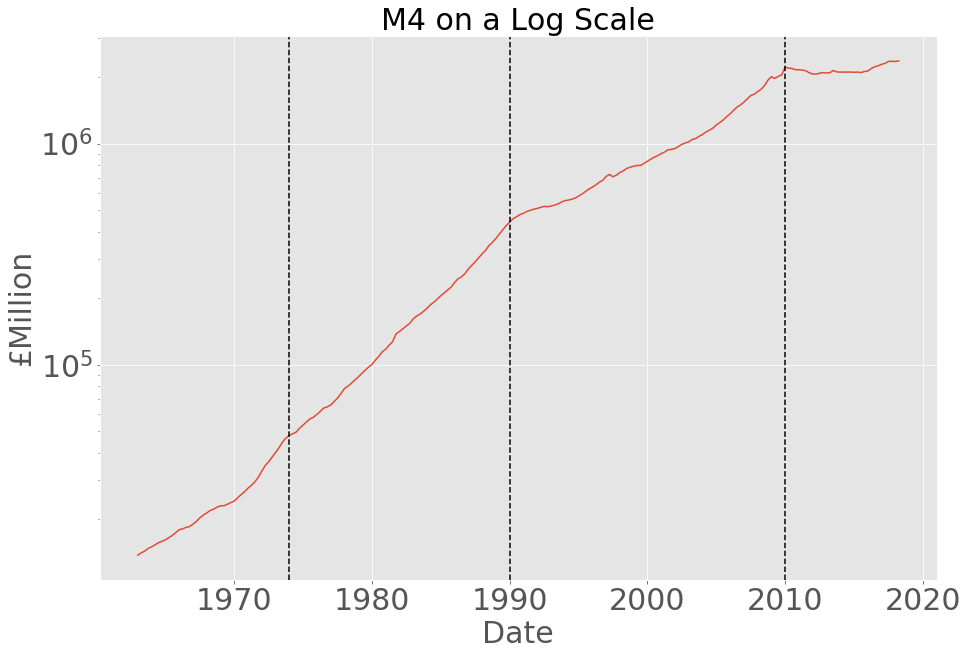

In [5]:
#Plot the M4 quarterly data on a log scale
plt.figure(figsize=(15,10))
plt.plot(datesM4,M4v)
plt.title('M4 on a Log Scale',fontsize=30)
plt.xlabel('Date',fontsize=30)
plt.ylabel('£Million',fontsize=30)
plt.yscale('log')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.axvline(1974,color='black',linestyle='--')
plt.axvline(1990,color='black',linestyle='--')
plt.axvline(2010,color='black',linestyle='--')



For a time series $\{x_i\}_{i=1}^N$ we define the rate of change as 
$\{\frac{x_{i+1}}{x_i}\}_{i=1}^{N-1}$.

We smooth this data by taking a running mean
https://stackoverflow.com/questions/13728392/moving-average-or-running-mean

In [6]:
#Make the rate of change of M4 time series data, note it's length is one less than the original data
datesM4roc=datesM4[1:len(datesM4)]
M4_rate_of_change=rate_of_change(M4v) #rate of change function in functions file


#Smooth the M4 rate of change with a four-fold running average, note this is 3 less than original data
M4roc_smooth=running_mean(M4_rate_of_change,4) #running mean function in function file
datesM4roc_smooth=datesM4roc[3:len(datesM4roc)]

print(len(M4_rate_of_change))
print(len(M4roc_smooth))

221
218


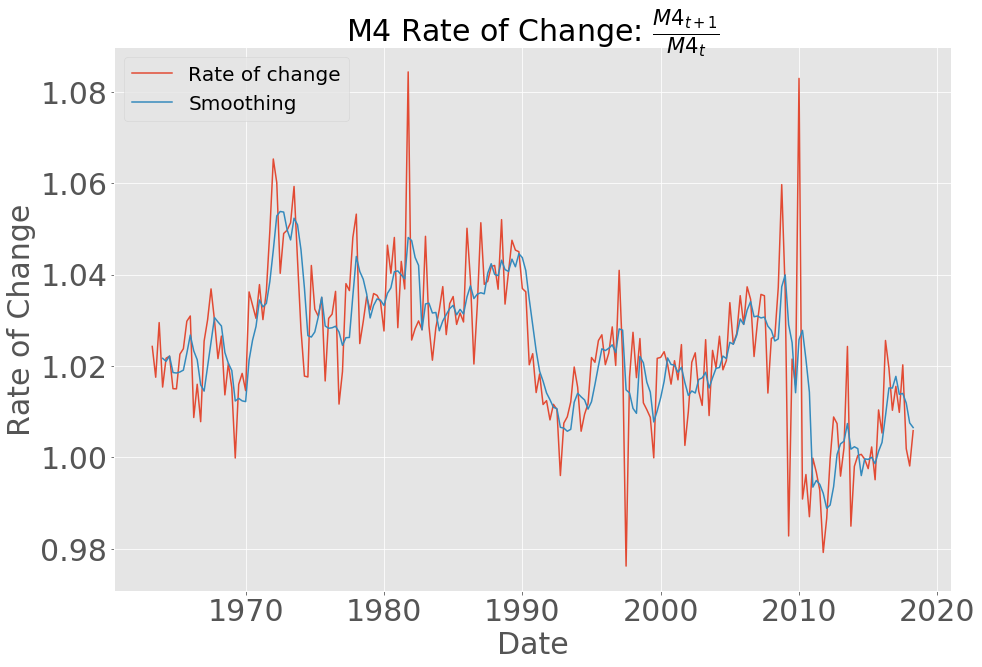

In [7]:
#Plot of M4 rate of change and four-fold smoothed data
plt.figure(figsize=(15,10))
plt.plot(datesM4roc,M4_rate_of_change,label='Rate of change')
plt.plot(datesM4roc_smooth,M4roc_smooth,label='Smoothing')
plt.title(r'M4 Rate of Change: $\frac{M4_{t+1}}{M4_{t}}$',fontsize=30)
plt.xlabel('Date',fontsize=30)
plt.ylabel('Rate of Change',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)



We check for unit roots by using the augmented Dickey fuller test. If process has a root it is non-stationary

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html



In [8]:
x=np.arange(0,10000,0.1)

np.var(np.sin(x))

0.499984993267219

In [9]:
#Import adfuller function from package
from statsmodels.tsa.stattools import adfuller

/home/samuel/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [10]:
a1=adfuller(M4_rate_of_change)
a2=adfuller(M4roc_smooth)

print(a1)
print('')
print(a2)

#Augmented Dickey Fuller test => both not stationary (second value is p-value)

(-2.2811978956606733, 0.1781037445543382, 4, 216, {'1%': -3.4609922013325267, '5%': -2.875015740963014, '10%': -2.5739524288408777}, -1199.1742735208095)

(-1.9734162608091859, 0.2983493803296856, 13, 204, {'1%': -3.462818103072159, '5%': -2.8758145932936805, '10%': -2.574378674548251}, -1690.8280604636843)


Want to make rate of change data stationary. Can do this by dividing by the regression tree of the data.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

https://sahirbhatnagar.com/assets/pdf/cart_animation_EN_Feb19_Final.pdf



In [11]:
#Import regression tree package
from sklearn.tree import DecisionTreeRegressor

In [12]:
#Define regression trees with max-depth 2 or 3
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2= DecisionTreeRegressor(max_depth=3)

#Reshape the rate of change smoothed data in form for regression tree function to work
xM4smooth=datesM4roc_smooth.reshape(-1,1)
yM4smooth=M4roc_smooth.reshape(-1,1)

#Fit on the smoothed data with both depths
regr_1.fit(xM4smooth,yM4smooth)
regr_2.fit(xM4smooth,yM4smooth)

#Predict on the same data to get values for regression tree
y_1M4smooth = regr_1.predict(xM4smooth)
y_2M4smooth = regr_2.predict(xM4smooth)

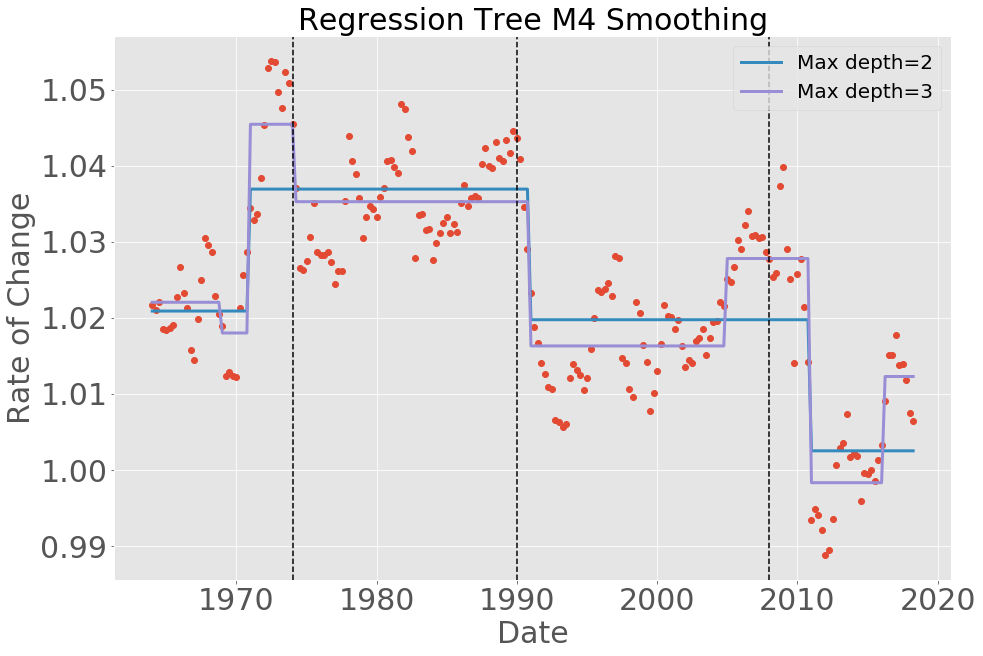

In [13]:
#Plot the smoothed data and the regression trees with max depth 2 and 3

plt.figure(figsize=(15,10))
plt.plot(xM4smooth,yM4smooth,'o')
plt.plot(xM4smooth,y_1M4smooth,linewidth=3,label='Max depth=2')
plt.plot(xM4smooth,y_2M4smooth,linewidth=3,label='Max depth=3')
plt.title('Regression Tree M4 Smoothing',fontsize=30)
plt.xlabel('Date',fontsize=30)
plt.ylabel('Rate of Change',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.axvline(1974,color='black',linestyle='--')
plt.axvline(1990,color='black',linestyle='--')
plt.axvline(2008,color='black',linestyle='--')
plt.legend(fontsize=20)



Use method of calculating MSEs to prevent overfitting, result highly dependent on training and testing set

https://datascience.stackexchange.com/questions/26640/how-to-check-for-overfitting-with-svm-and-iris-data

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X=xM4smooth
y=yM4smooth

#Split data randomly into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=51)

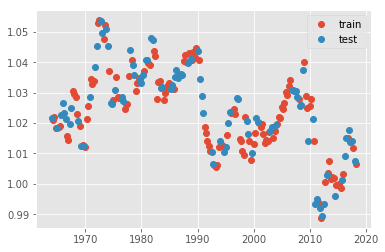

In [15]:
#Plot of training and testing set
plt.plot(X_train,y_train,'o',label='train')
plt.plot(X_test,y_test,'o',label='test')
plt.legend(fontsize=10)

In [16]:
#Predictions on training set
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2= DecisionTreeRegressor(max_depth=3)

regr_1.fit(X_train,y_train)
regr_2.fit(X_train,y_train)


predictions1tr=regr_1.predict(X_train)
predictions2tr=regr_2.predict(X_train)

print(mean_squared_error(predictions1tr,y_train)) #Note very small mean squared error due 
#to small differences in data values
print(mean_squared_error(predictions2tr,y_train))


5.001108694783275e-05
3.0405273901894076e-05


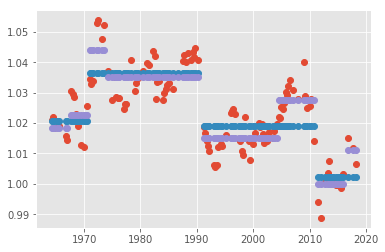

In [17]:
#Plot of regression tree and training data
plt.plot(X_train,y_train,'o')
plt.plot(X_train,predictions1tr,'o')
plt.plot(X_train,predictions2tr,'o')

In [18]:
#Mean squared error for prediction on training and test sets after fitting on training data
#for different depths of tree
MSE_train=[]
MSE_test=[]
for k in range(1,10):
    regr = DecisionTreeRegressor(max_depth=k)
    regr.fit(X_train,y_train)
    predictions_train=regr.predict(X_train)
    predictions_test=regr.predict(X_test)
    mse_train=mean_squared_error(predictions_train,y_train)
    mse_test=mean_squared_error(predictions_test,y_test)
    MSE_train.append(mse_train)
    MSE_test.append(mse_test)

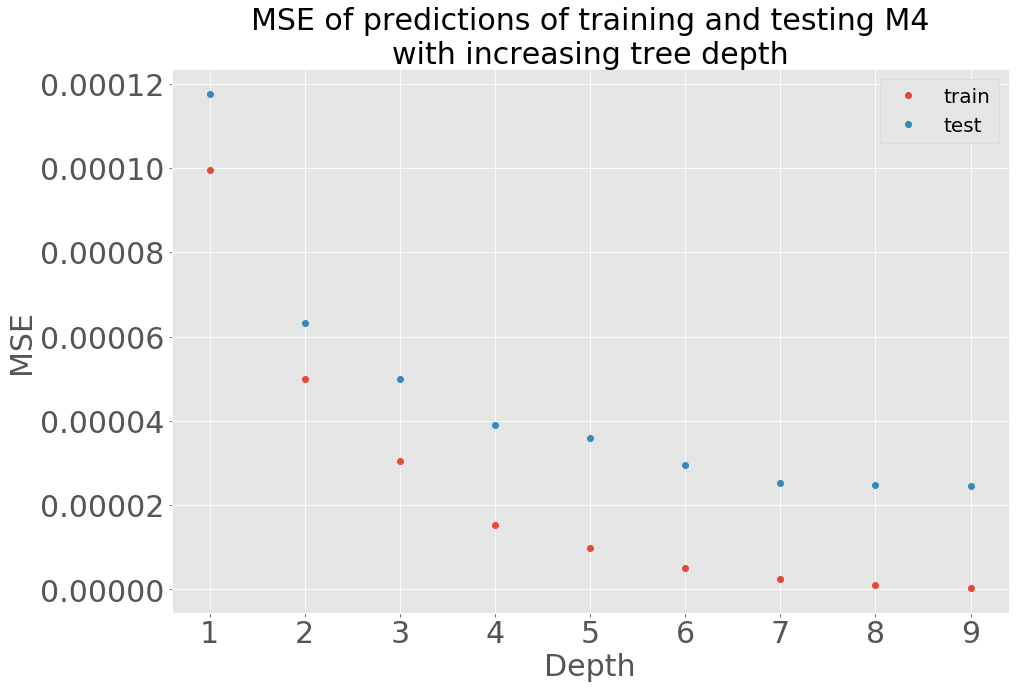

In [19]:
#Plot of MSE of predictions on training and testing set
plt.figure(figsize=(15,10))
r=range(1,10)
plt.plot(r,MSE_train,'o',label='train')
plt.plot(r,MSE_test,'o',label='test')

plt.title(r"MSE of predictions of training and testing M4" "\n" r"with increasing tree depth",fontsize=30)
plt.xlabel('Depth',fontsize=30)
plt.ylabel('MSE',fontsize=30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)



K-fold cross-validation with different depths of decision tree
<br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [20]:
from sklearn.model_selection import KFold

#10 folds
kf = KFold(n_splits=20)

s=kf.get_n_splits(X)

t=10

#Define matrix to hold MSE: rows are for the depth, columns for the split
MSE=np.zeros((t,s))



for k in range(1,t+1):
    count=0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regr = DecisionTreeRegressor(max_depth=k)
        regr.fit(X_train,y_train)
        prediction = regr.predict(X_test)
        mse=mean_squared_error(prediction,y_test)
        MSE[k-1,count]=mse
        count+=1
        

In [21]:
print(len(X_train))
print(len(X))

208
218


In [22]:
#Find the mean of the MSEs of the depths of each of the rows
MSE_mean=[]

for i in range(t):
    MSE_mean.append(np.mean(MSE[i,:]))

In [23]:
#Find the depth with minimum mean squared error, note dependant on number of folds
a=np.asarray(MSE_mean,float)
np.where(a == a.min())

mymin = np.min(a)
min_positions = [i for i, x in enumerate(a) if x == mymin]

m=min_positions[0]+1

print(m)


7


(array([7.0e-05, 8.0e-05, 9.0e-05, 1.0e-04, 1.1e-04, 1.2e-04, 1.3e-04,
        1.4e-04, 1.5e-04, 1.6e-04]), <a list of 10 Text yticklabel objects>)

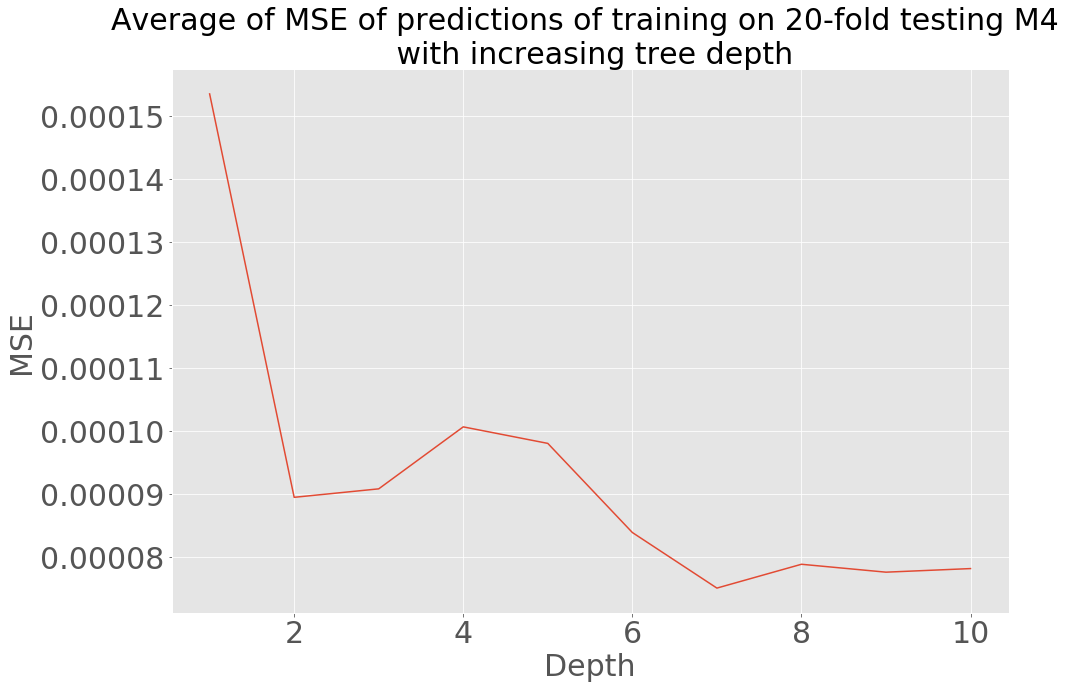

In [24]:
#Plot of 10-fold MSE on testing set
plt.figure(figsize=(15,10))
r=range(1,t+1)
plt.plot(r,MSE_mean)

plt.title("Average of MSE of predictions of training on {}-fold testing M4 \
\n with increasing tree depth".format(s),fontsize=30)
plt.xlabel('Depth',fontsize=30)
plt.ylabel('MSE',fontsize=30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Hodrick Prescott Filter M4


Common method to detrend data 

https://www.statsmodels.org/dev/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html

# Start

In [25]:
import statsmodels.api as sm

cycleM4roc, trendM4roc = sm.tsa.filters.hpfilter(M4roc_smooth, 1600) #finds cyclical and trend component
#using HP filter

(array([-0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,
         0.02 ]), <a list of 9 Text yticklabel objects>)

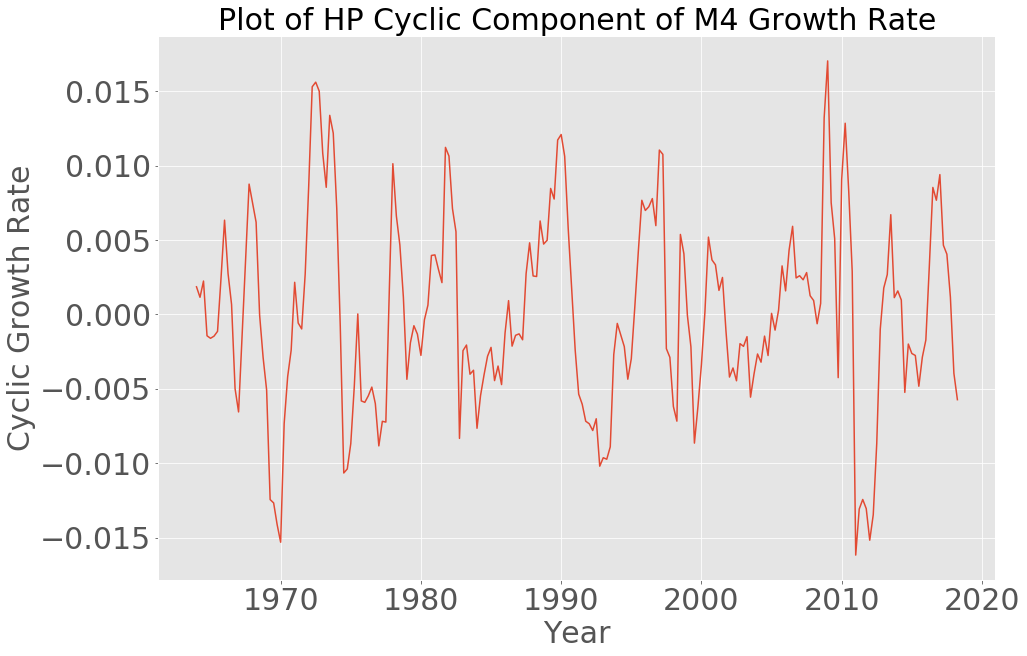

In [26]:
#plot of cyclic component
plt.figure(figsize=(15,10))
plt.plot(xM4smooth,cycleM4roc)

plt.title('Plot of HP Cyclic Component of M4 Growth Rate',fontsize=30)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Cyclic Growth Rate',fontsize=30)


plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

(array([0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06]),
 <a list of 9 Text yticklabel objects>)

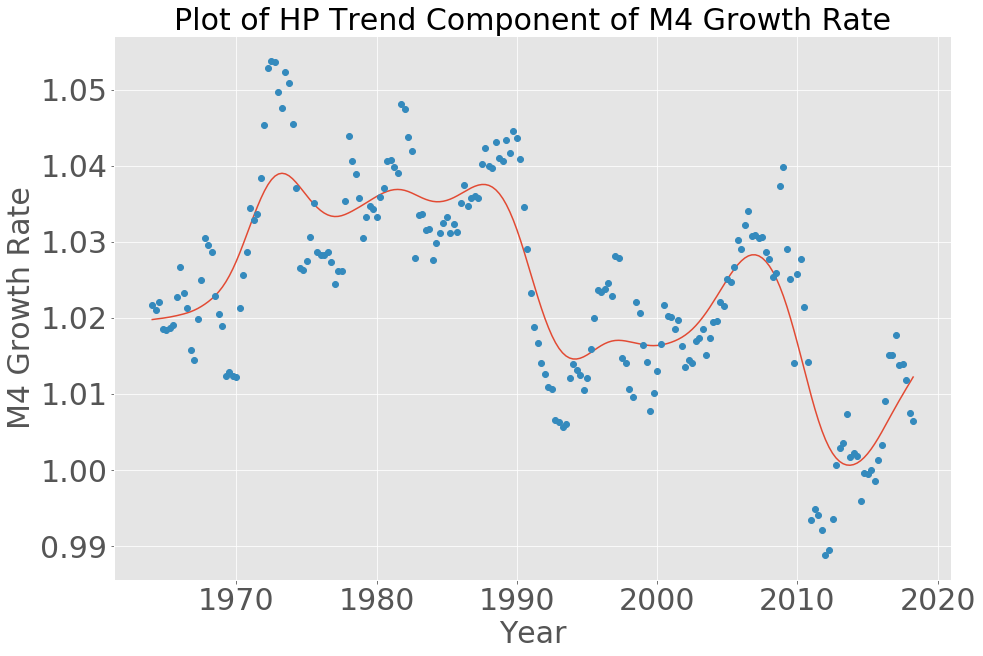

In [27]:
#Plot of trend component on rate of change data for M4
plt.figure(figsize=(15,10))
plt.plot(xM4smooth,trendM4roc)
plt.plot(xM4smooth,yM4smooth,'o')

plt.title('Plot of HP Trend Component of M4 Growth Rate',fontsize=30)
plt.xlabel('Year',fontsize=30)
plt.ylabel('M4 Growth Rate',fontsize=30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

In [28]:
#Augmented Dickey Fuller test, p-value <0.01 => accept null that data is stationary..
#(does not have unit root)
adfuller(cycleM4roc)

(-5.324608409242839,
 4.868253315234428e-06,
 13,
 204,
 {'1%': -3.462818103072159,
  '10%': -2.574378674548251,
  '5%': -2.8758145932936805},
 -1736.3592079176)

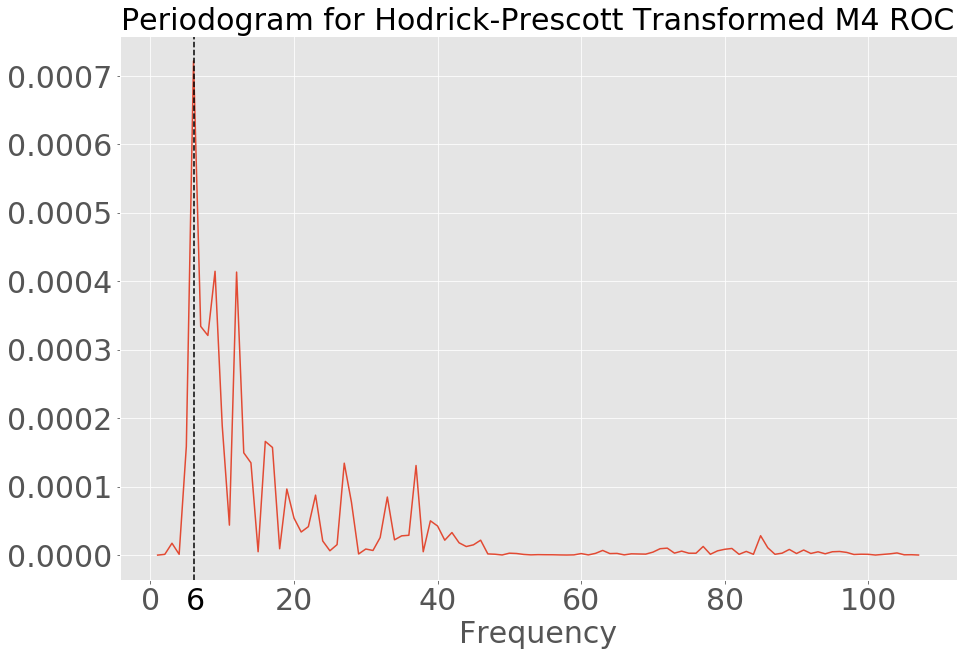

In [29]:
#Periodogram of rate of change of M4 of cyclic component
plt.figure(figsize=(15,10))
p=periodogram(cycleM4roc)

q=int((len(p)-1)/2)
plt.plot(range(1,q),p[1:q])
plt.title('Periodogram for Hodrick-Prescott Transformed M4 ROC',fontsize=30)
plt.xlabel('Frequency',fontsize=30) 

plt.axvline(6,color='black',linestyle='--')

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.text(5,-0.00008,'6',fontsize=30)

plt.savefig(direc_save+'M4_HP_periodogram')

# End

In [30]:
#Transform M4 roc data by dividing by decision tree with max-depth 2
M4roc_transform1=M4roc_smooth/y_1M4smooth

#Second transform M4 roc data by taking logs of previous transform
M4roc_transform2=np.log(M4roc_smooth/y_1M4smooth)

(array([0.98 , 0.985, 0.99 , 0.995, 1.   , 1.005, 1.01 , 1.015, 1.02 ,
        1.025]), <a list of 10 Text yticklabel objects>)

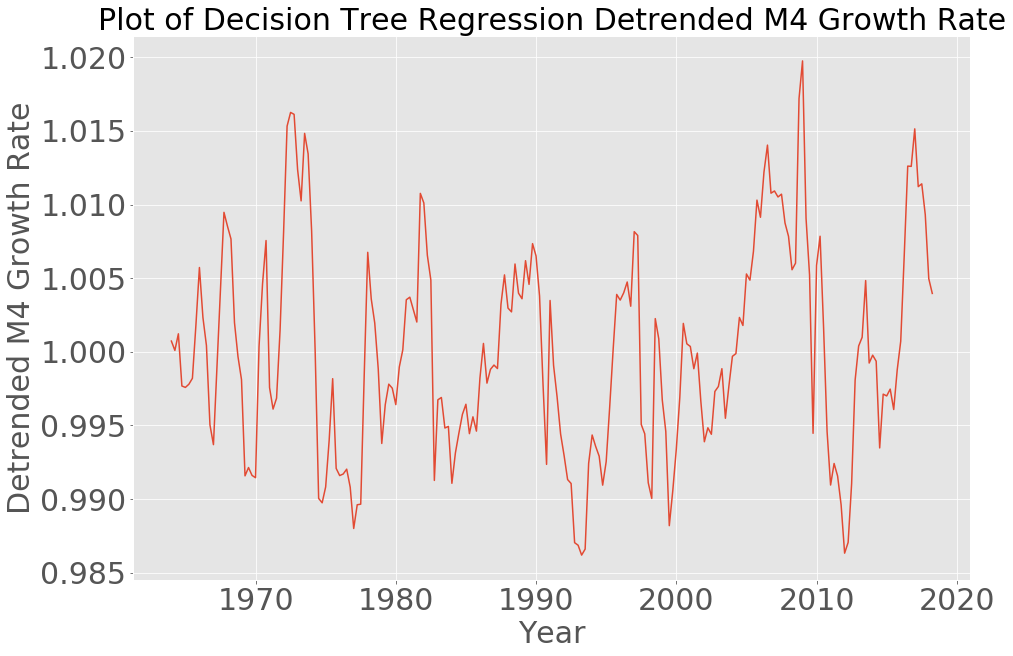

In [31]:
#Plot of transformed data with first transform
plt.figure(figsize=(15,10))
plt.plot(xM4smooth,M4roc_transform1)

plt.title('Plot of Decision Tree Regression Detrended M4 Growth Rate',fontsize=30)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Detrended M4 Growth Rate',fontsize=30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

(array([-0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,
         0.02 ,  0.025]), <a list of 10 Text yticklabel objects>)

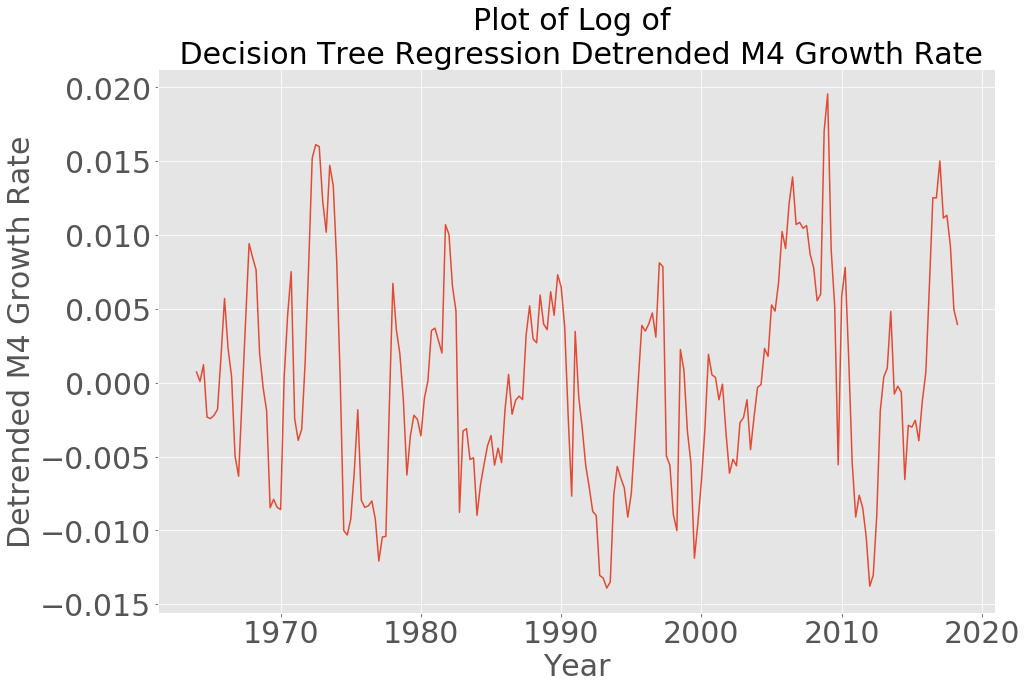

In [32]:
#Plot of transformed data with second transform
plt.figure(figsize=(15,10))
plt.plot(xM4smooth,M4roc_transform2)

plt.title('Plot of Log of \n Decision Tree Regression Detrended M4 Growth Rate',fontsize=30)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Detrended M4 Growth Rate',fontsize=30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

In [33]:
#Augmented Dickey-Fuller test on first transform implies no unit roots
adfuller(M4roc_transform1)

(-4.477375839137053,
 0.00021600173939185447,
 10,
 207,
 {'1%': -3.4623415245233145,
  '10%': -2.574267439846904,
  '5%': -2.875606128263243},
 -1697.325732914565)

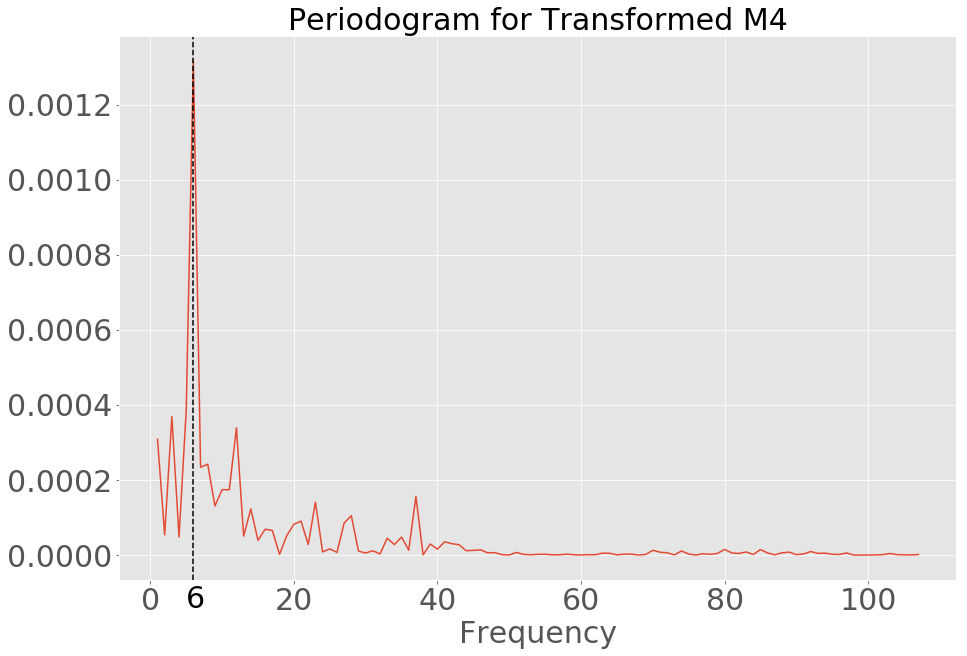

In [34]:
#Periodogram of transformed M4 data
plt.figure(figsize=(15,10))
p=periodogram(M4roc_transform1)

q=int((len(p)-1)/2)# Periodogram symmetric, plot only first half
plt.plot(range(1,q),p[1:q]) #Don't include 0th frequency as it is so comparably large and does not give 
#relevant info
plt.title('Periodogram for Transformed M4',fontsize=30)
plt.xlabel('Frequency',fontsize=30)

plt.axvline(6,color='black',linestyle='--')

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.text(5,-0.00014,'6',fontsize=30)

plt.savefig(direc_save+'M4_periodogram')

In [35]:
#Fit periods based on the frequencies (divide total length of years by frequency)

r=xM4smooth[len(xM4smooth)-1]-xM4smooth[0]
r=r[0]
periodM4=[]

for i in range(1,q):
    periodM4.append(r/i)



In [36]:
periodM4h=round(periodM4[5],2)

In [37]:
print(periodM4h) #Period with frequency 6

9.04


Text(9,0,'9.04')

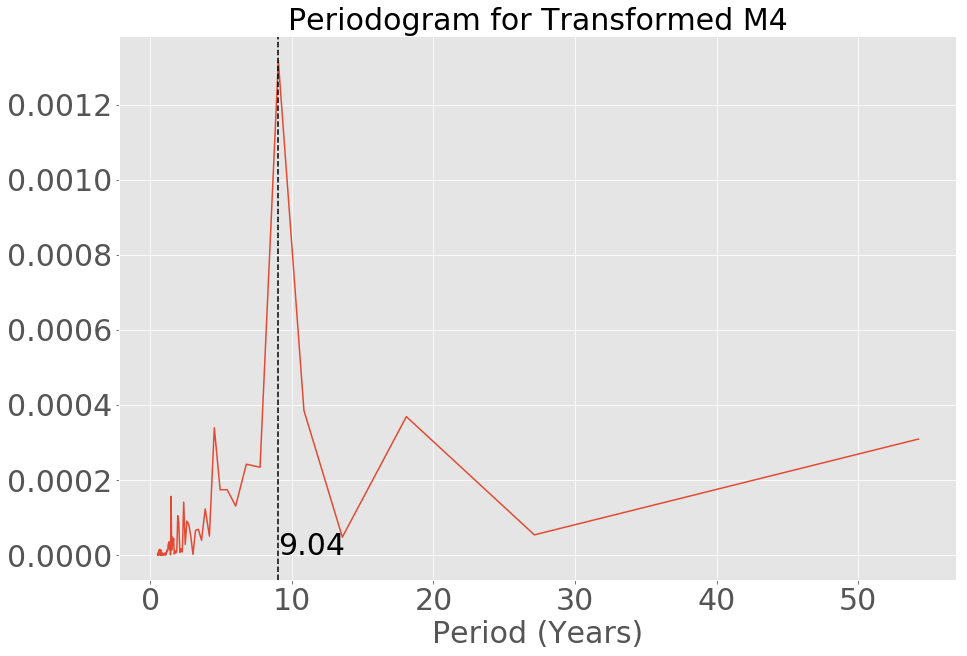

In [38]:
#Plot of periodogram with periods
plt.figure(figsize=(15,10))
p=periodogram(M4roc_transform1)

q=int((len(p)-1)/2)
plt.plot(periodM4,p[1:q])
plt.title('Periodogram for Transformed M4',fontsize=30)
plt.xlabel('Period (Years)',fontsize=30)


plt.axvline(periodM4[5],color='black',linestyle='--')

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.text(9,0,'{c}'.format(c=periodM4h),fontsize=30)

In [39]:
#Find the beginning of each new cycle with period 6
periods=[]
years=[]
for i in range(1,6):
    per=xM4smooth[0][0]+i*periodM4[5]
    y=i*periodM4[5]
    periods.append(per)
    years.append(y)

In [40]:
periods
years

[9.041666666666666,
 18.083333333333332,
 27.125,
 36.166666666666664,
 45.20833333333333]

/home/samuel/.local/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


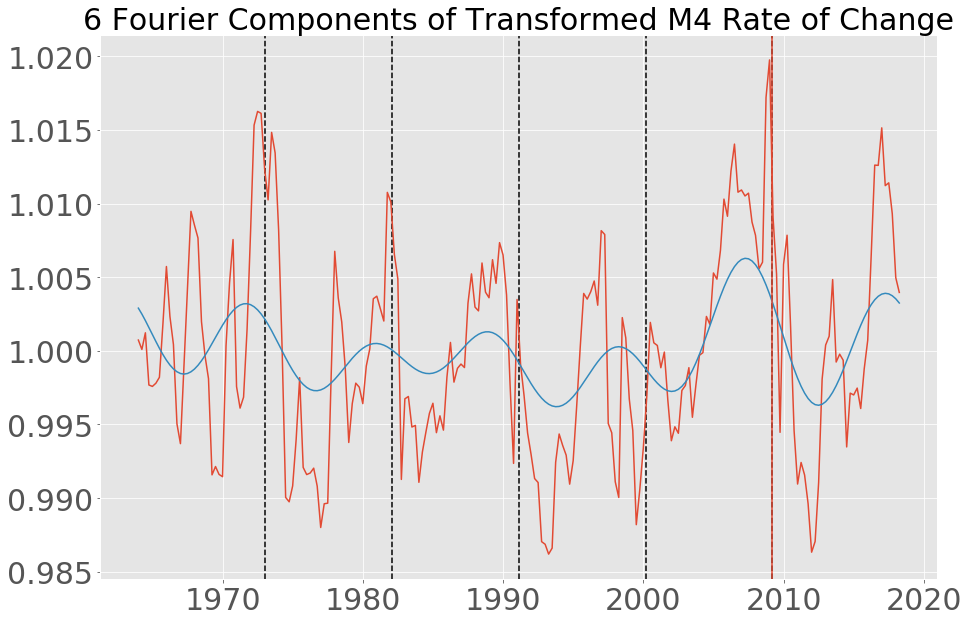

In [41]:
plt.figure(figsize=(15,10))
x=xM4smooth
y=M4roc_transform1

n = len(y)
Y=np.fft.fft(y)


for i in range(len(periods)):
    plt.axvline(periods[i],color='black',linestyle='--')

c=6

#Inverse Fourier transform of first 6 componenets of Fourier transform
np.put(Y, range(c+1, n), 0.0)

ifft=np.fft.ifft(Y)

plt.plot(x,y)
plt.plot(x,ifft) #Plotting real part

plt.title('{c} Fourier Components of Transformed M4 Rate of Change'.format(c=c),fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.axvline(per)
plt.savefig(direc_save+'M4_inv_period')



<div style="font-size: 17px">

Autocorrelation defined as:
\begin{equation*}
r_k = \displaystyle
\dfrac{\sum\limits_{t=1}^{N-k} (x_k-\bar{x})(x_{t+k}-\bar{x})}{\sum\limits_{t=1}^N(x_t-\bar{x})^2}.
\end{equation*}

In [42]:
#Find the time in years starting with first data value at 0
xs=np.arange(0,(len(xM4smooth)-1)/4,0.25)

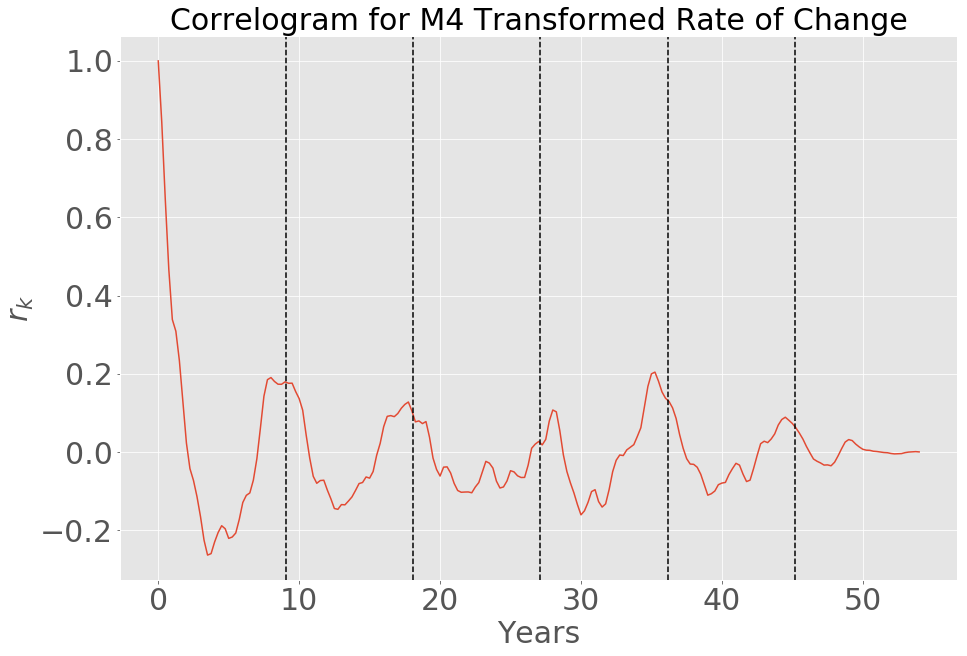

In [43]:
#Plot of correlogram for M4 transformed rate of change
plt.figure(figsize=(15,10))
plt.plot(xs,AUT1(M4roc_transform1))
plt.title('Correlogram for M4 Transformed Rate of Change',fontsize=30)
plt.ylabel(r'$r_k$',fontsize=30)
plt.xlabel('Years',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

for i in range(len(years)):
    plt.axvline(years[i],color='black',linestyle='--')
plt.savefig(direc_save+'M4_cor')

# NGDP 



Do same as for M4 data but on NGDP

In [44]:
dataNGDP=pd.read_csv(NGDP)
dataNGDP=dataNGDP.values
NGDPx=dataNGDP[:,0] #dates 1955-2018, quarterly, strings
NGDPy=dataNGDP[:,1]
NGDP=NGDPy.astype(np.float) #NGDP as float

datesNGDP=np.arange(1955,2018.25,0.25)

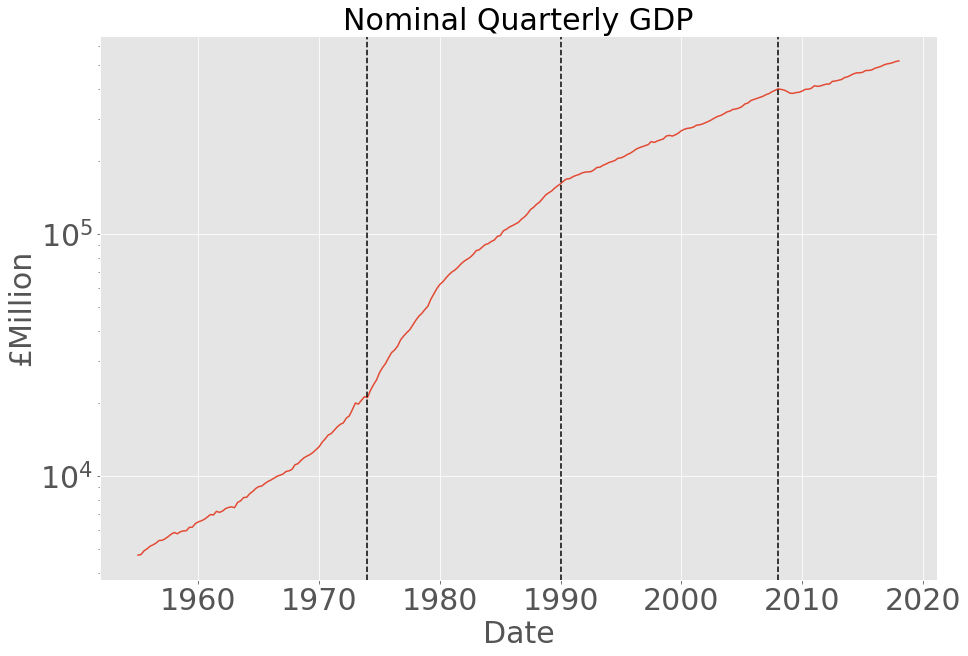

In [45]:
plt.figure(figsize=(15,10))
plt.plot(datesNGDP,NGDP)
plt.title('Nominal Quarterly GDP',fontsize=30)
plt.xlabel('Date',fontsize=30)
plt.ylabel('£Million',fontsize=30)
plt.yscale('log')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.axvline(1974,color='black',linestyle='--')
plt.axvline(1990,color='black',linestyle='--')
plt.axvline(2008,color='black',linestyle='--')

In [46]:
NGDP_rate_of_change=rate_of_change(NGDP)
datesNGDProc=datesNGDP[1:len(datesNGDP)]

NGDProc_smooth=running_mean(NGDP_rate_of_change,4)
datesNGDProc_smooth=datesNGDProc[3:len(datesNGDProc)]

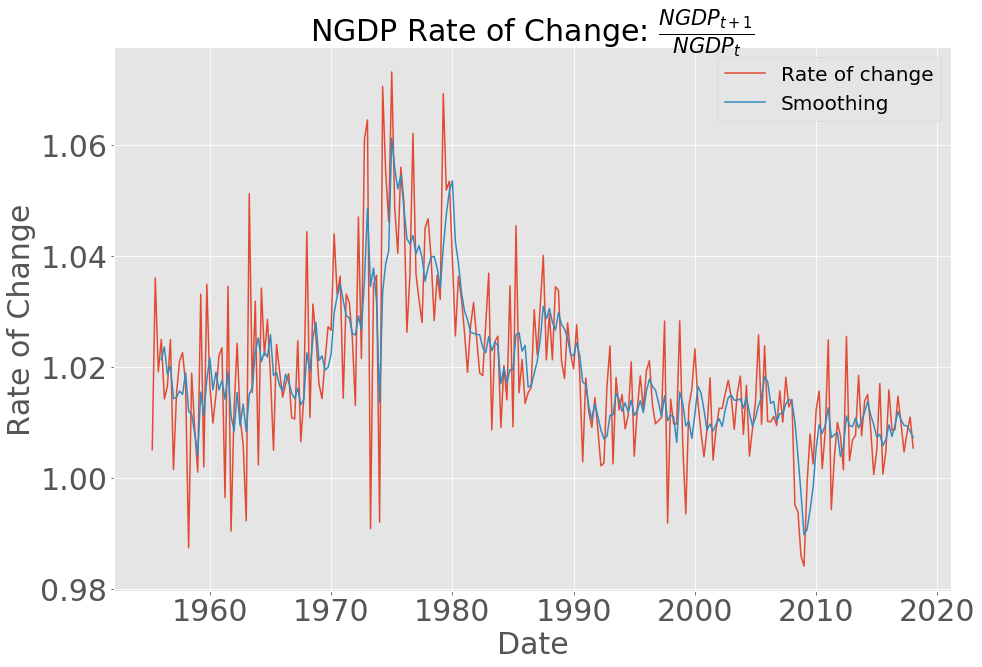

In [47]:
plt.figure(figsize=(15,10))
plt.plot(datesNGDProc,NGDP_rate_of_change,label='Rate of change')
plt.plot(datesNGDProc_smooth,NGDProc_smooth,label='Smoothing')
plt.title(r'NGDP Rate of Change: $\frac{NGDP_{t+1}}{NGDP_{t}}$',fontsize=30)
plt.xlabel('Date',fontsize=30)
plt.ylabel('Rate of Change',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)

In [48]:
n1=adfuller(NGDP_rate_of_change)
n2=adfuller(NGDProc_smooth)

print(n1)
print('')
print(n2)

(-1.4723999911588679, 0.5471178235974683, 9, 242, {'1%': -3.457664132155201, '5%': -2.8735585105960224, '10%': -2.5731749894132916}, -1411.3998558634107)

(-1.0179339807926562, 0.7466672257916063, 16, 232, {'1%': -3.458854867412691, '5%': -2.8740800599399323, '10%': -2.573453223097503}, -1989.1966948836025)


In [49]:
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2= DecisionTreeRegressor(max_depth=3)

xNGDPsmooth=datesNGDProc_smooth.reshape(-1,1)
yNGDPsmooth=NGDProc_smooth.reshape(-1,1)

regr_1.fit(xNGDPsmooth,yNGDPsmooth)
regr_2.fit(xNGDPsmooth,yNGDPsmooth)

y_1NGDPsmooth = regr_1.predict(xNGDPsmooth)
y_2NGDPsmooth = regr_2.predict(xNGDPsmooth)

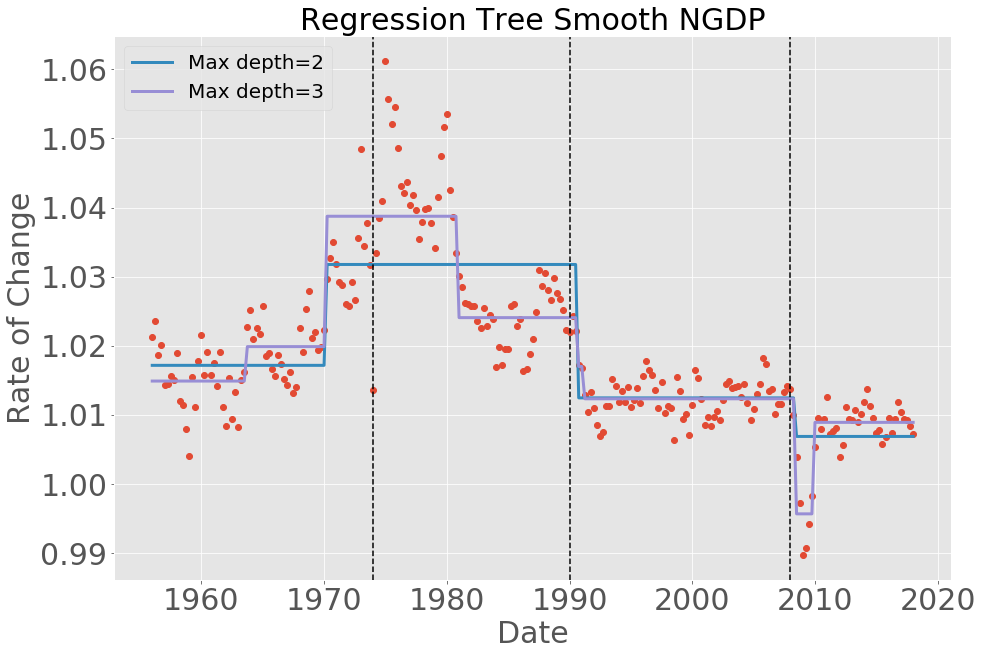

In [50]:
plt.figure(figsize=(15,10))
plt.plot(xNGDPsmooth,yNGDPsmooth,'o')
plt.plot(xNGDPsmooth,y_1NGDPsmooth,linewidth=3,label='Max depth=2')
plt.plot(xNGDPsmooth,y_2NGDPsmooth,linewidth=3,label='Max depth=3')
plt.title('Regression Tree Smooth NGDP',fontsize=30)
plt.xlabel('Date',fontsize=30)
plt.ylabel('Rate of Change',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.axvline(1974,color='black',linestyle='--')
plt.axvline(1990,color='black',linestyle='--')
plt.axvline(2008,color='black',linestyle='--')
plt.legend(fontsize=20)

In [51]:
X=xNGDPsmooth
y=yNGDPsmooth

#Split data randomly into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=51)

In [52]:
#Predictions on training set
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2= DecisionTreeRegressor(max_depth=3)

regr_1.fit(X_train,y_train)
regr_2.fit(X_train,y_train)


predictions1tr=regr_1.predict(X_train)
predictions2tr=regr_2.predict(X_train)

print(mean_squared_error(predictions1tr,y_train)) #Note very small mean squared error due 
#to small differences in data values
print(mean_squared_error(predictions2tr,y_train))

4.3397860347069925e-05
2.0779190024722488e-05


In [53]:
#Mean squared error for prediction on training and test sets after fitting on training data
#for different depths of tree
MSE_train=[]
MSE_test=[]
for k in range(1,10):
    regr = DecisionTreeRegressor(max_depth=k)
    regr.fit(X_train,y_train)
    predictions_train=regr.predict(X_train)
    predictions_test=regr.predict(X_test)
    mse_train=mean_squared_error(predictions_train,y_train)
    mse_test=mean_squared_error(predictions_test,y_test)
    MSE_train.append(mse_train)
    MSE_test.append(mse_test)

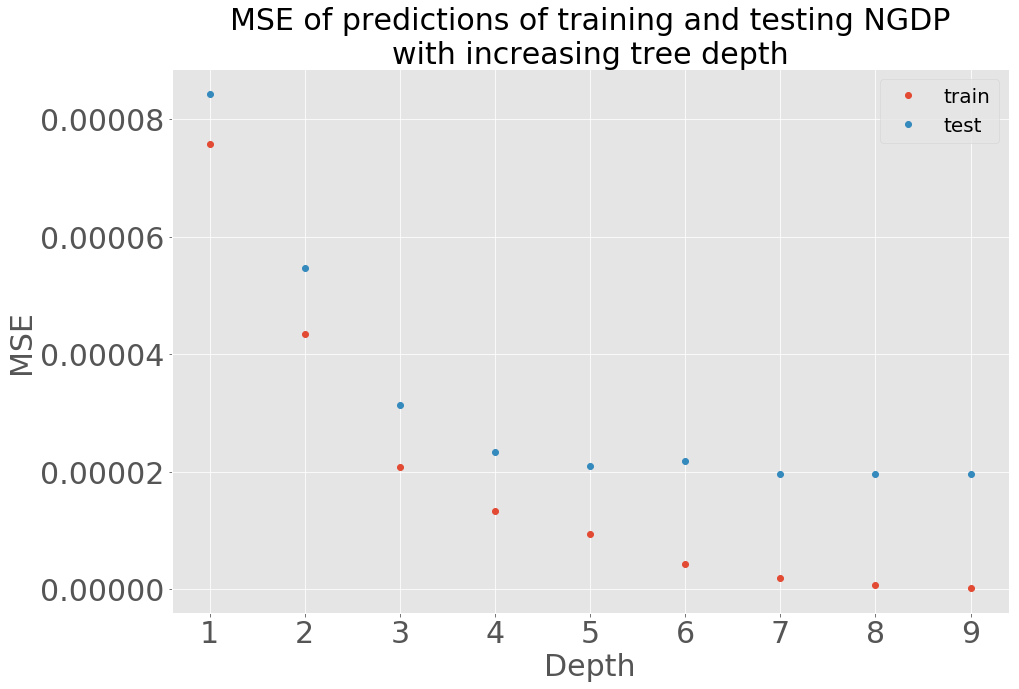

In [54]:
plt.figure(figsize=(15,10))
r=range(1,10)
plt.plot(r,MSE_train,'o',label='train')
plt.plot(r,MSE_test,'o',label='test')

plt.title(r"MSE of predictions of training and testing NGDP" "\n" r"with increasing tree depth",fontsize=30)
plt.xlabel('Depth',fontsize=30)
plt.ylabel('MSE',fontsize=30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)

In [55]:
kf = KFold(n_splits=10)

s=kf.get_n_splits(X)

t=10

#Define matrix to hold MSE: rows are for the depth, columns for the split
MSE=np.zeros((t,s))

for k in range(1,t+1):
    count=0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regr = DecisionTreeRegressor(max_depth=k)
        regr.fit(X_train,y_train)
        prediction = regr.predict(X_test)
        mse=mean_squared_error(prediction,y_test)
        MSE[k-1,count]=mse
        count+=1

#Find the mean of the MSEs of the depths of each of the rows
MSE_mean=[]

for i in range(t):
    MSE_mean.append(np.mean(MSE[i,:]))

#Find the depth with minimum mean squared error, note dependant on number of folds
a=np.asarray(MSE_mean,float)
np.where(a == a.min())

mymin = np.min(a)
min_positions = [i for i, x in enumerate(a) if x == mymin]

m=min_positions[0]+1

print(m)

9


(array([5.0e-05, 6.0e-05, 7.0e-05, 8.0e-05, 9.0e-05, 1.0e-04, 1.1e-04]),
 <a list of 7 Text yticklabel objects>)

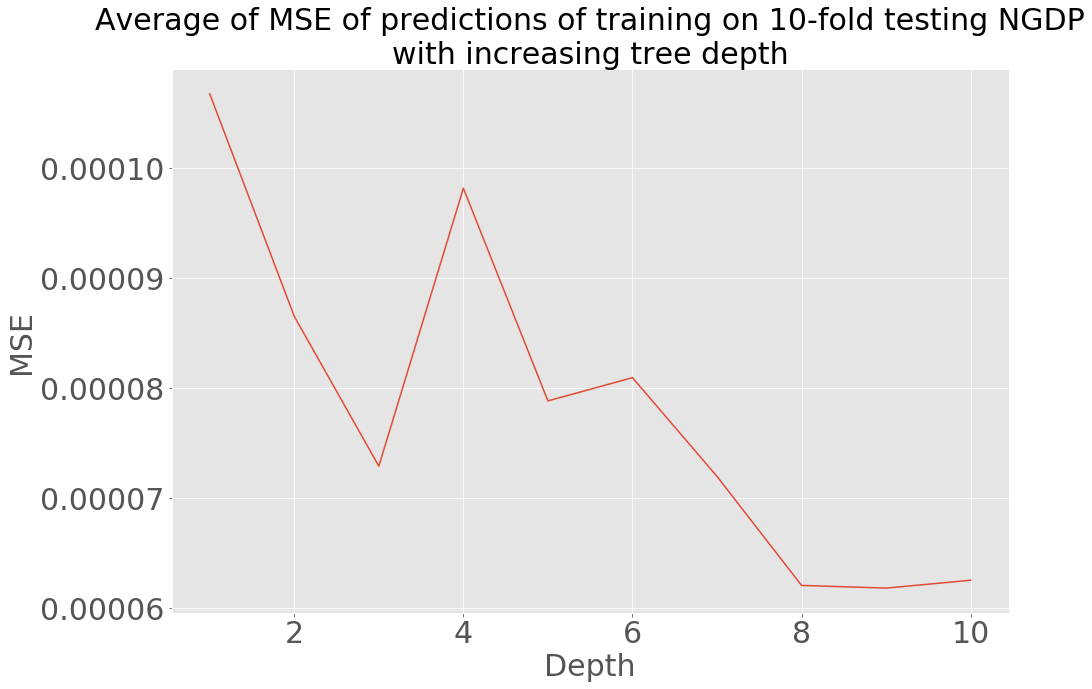

In [56]:
plt.figure(figsize=(15,10))
r=range(1,t+1)
plt.plot(r,MSE_mean)

plt.title(r"Average of MSE of predictions of training on 10-fold testing NGDP" "\n" r"with increasing tree depth",fontsize=30)
plt.xlabel('Depth',fontsize=30)
plt.ylabel('MSE',fontsize=30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

In [57]:
NGDProc_transform=NGDProc_smooth/y_2NGDPsmooth
NGDProc_transform1=NGDProc_smooth-y_2NGDPsmooth
NGDProc_transform2=NGDProc_smooth-np.mean(NGDProc_smooth)

(array([0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03]),
 <a list of 7 Text yticklabel objects>)

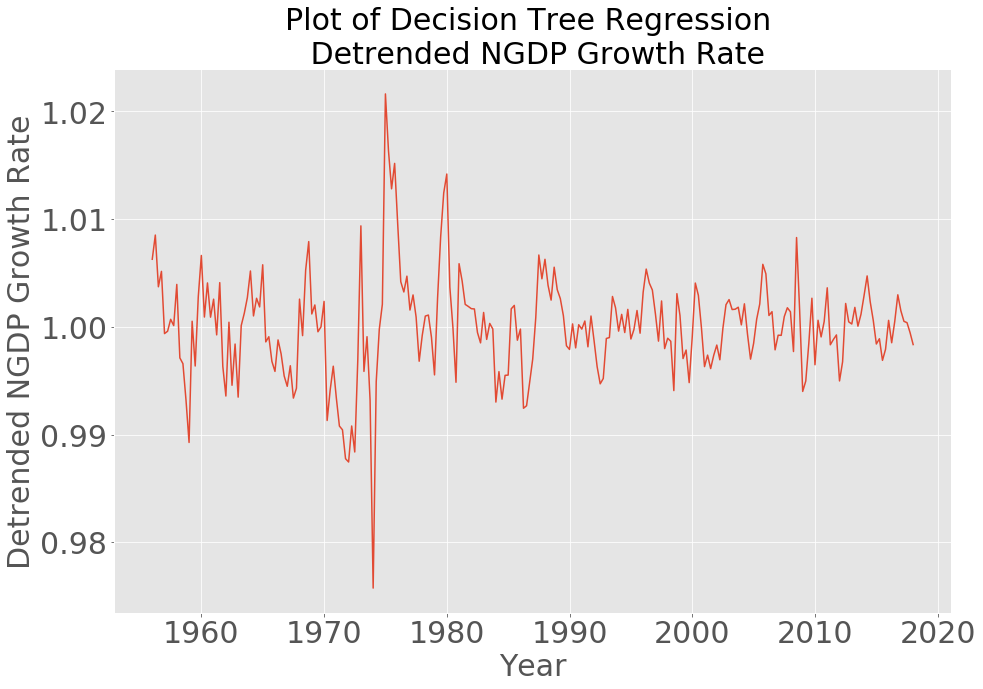

In [58]:
plt.figure(figsize=(15,10))
plt.plot(xNGDPsmooth,NGDProc_transform)
plt.title('Plot of Decision Tree Regression \n Detrended NGDP Growth Rate',fontsize=30)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Detrended NGDP Growth Rate',fontsize=30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

(array([-0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03]),
 <a list of 7 Text yticklabel objects>)

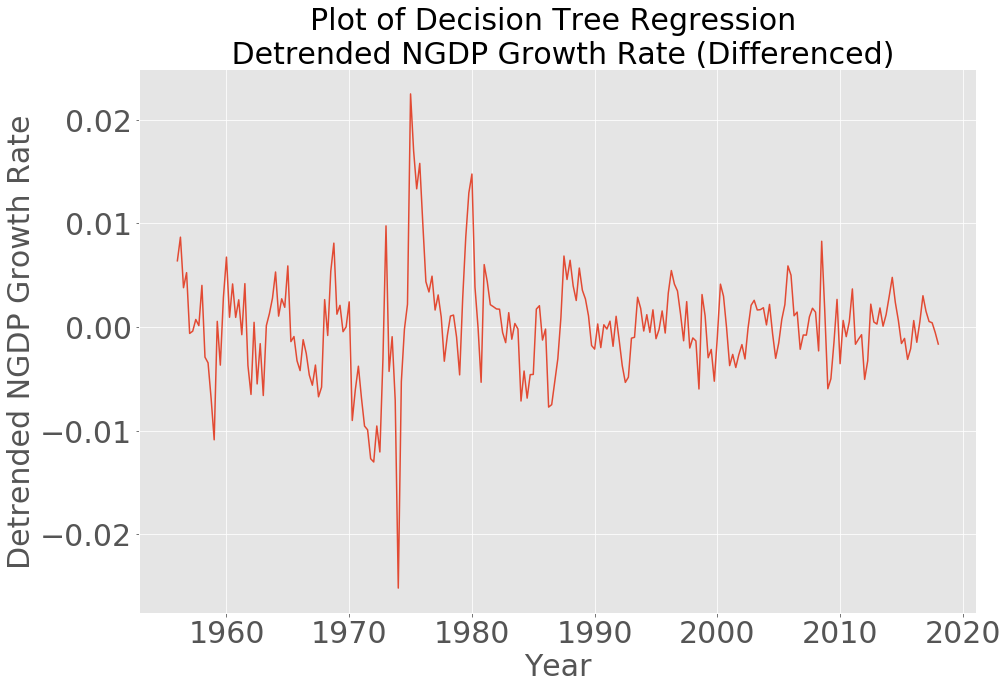

In [59]:
plt.figure(figsize=(15,10))
plt.plot(xNGDPsmooth,NGDProc_transform1)
plt.title('Plot of Decision Tree Regression \n Detrended NGDP Growth Rate (Differenced)',fontsize=30)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Detrended NGDP Growth Rate',fontsize=30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

In [60]:
adfuller(NGDProc_transform) #Implies data does not have unit root

(-4.837461700262601,
 4.6087809423122956e-05,
 9,
 239,
 {'1%': -3.458010773719797,
  '10%': -2.5732559963936206,
  '5%': -2.8737103617125186},
 -1955.5779257975137)

# Hodrick Prescott Filter NGDP 

# Start

In [61]:
cycleNGDProc, trendNGDProc = sm.tsa.filters.hpfilter(NGDProc_smooth, 1600)

(array([-0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03]),
 <a list of 7 Text yticklabel objects>)

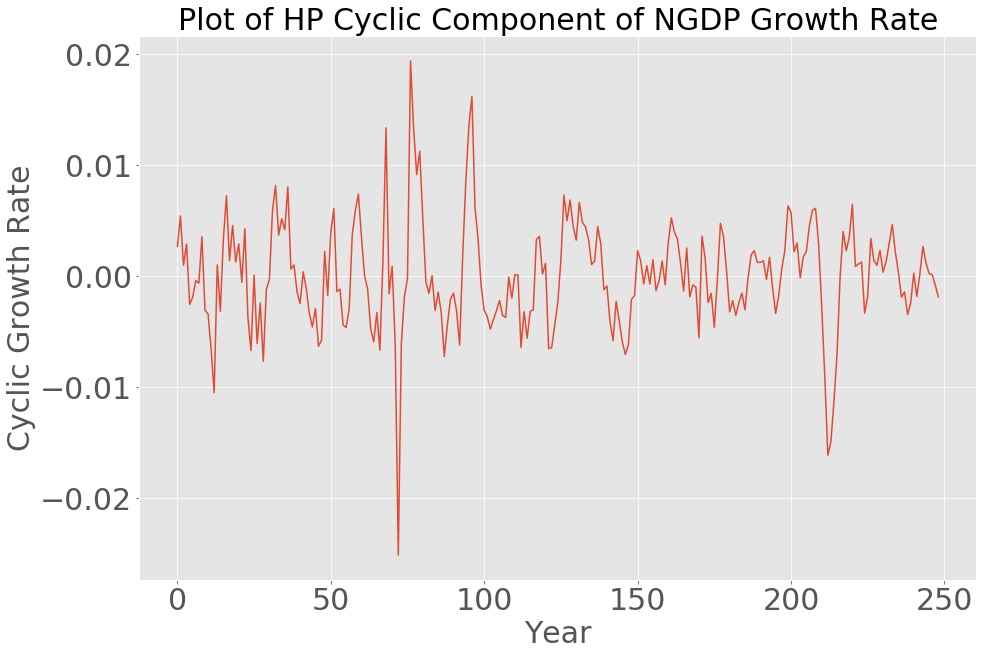

In [62]:
plt.figure(figsize=(15,10))
plt.plot(cycleNGDProc)
plt.title('Plot of HP Cyclic Component of NGDP Growth Rate',fontsize=30)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Cyclic Growth Rate',fontsize=30)


plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

(array([0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07]),
 <a list of 10 Text yticklabel objects>)

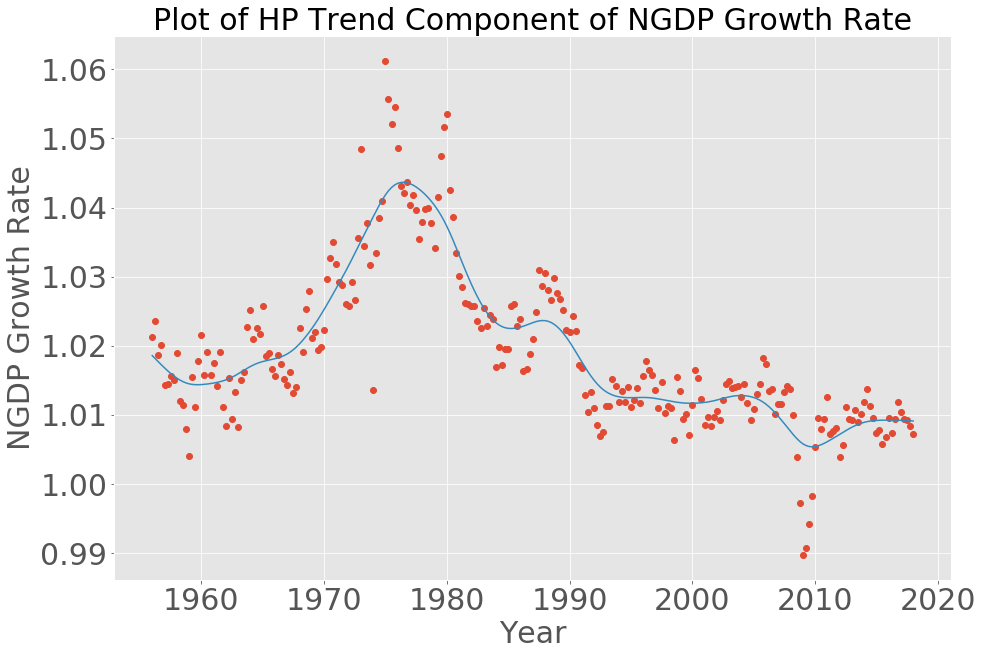

In [131]:
plt.figure(figsize=(15,10))
plt.plot(xNGDPsmooth,yNGDPsmooth,'o')
plt.plot(xNGDPsmooth,trendNGDProc)

plt.title('Plot of HP Trend Component of NGDP Growth Rate',fontsize=30)
plt.xlabel('Year',fontsize=30)
plt.ylabel('NGDP Growth Rate',fontsize=30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

In [64]:
adfuller(cycleNGDProc)

(-4.2339839758735165,
 0.0005768548822950376,
 16,
 232,
 {'1%': -3.458854867412691,
  '10%': -2.573453223097503,
  '5%': -2.8740800599399323},
 -2052.029850427906)

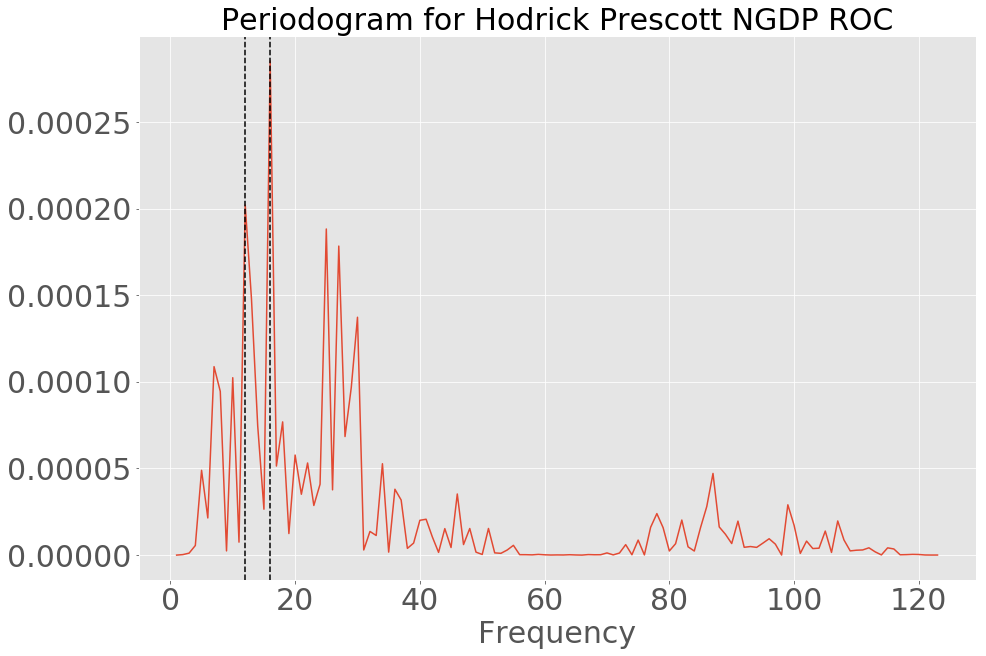

In [65]:
plt.figure(figsize=(15,10))
p1=periodogram(cycleNGDProc)

q1=int((len(p1)-1)/2)
plt.plot(range(1,q1),p1[1:q1])
plt.title('Periodogram for Hodrick Prescott NGDP ROC',fontsize=30)
plt.xlabel('Frequency',fontsize=30)

plt.axvline(12,color='black',linestyle='--')
plt.axvline(16,color='black',linestyle='--')

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.savefig(direc_save+'NGDP_HP_periodogram')

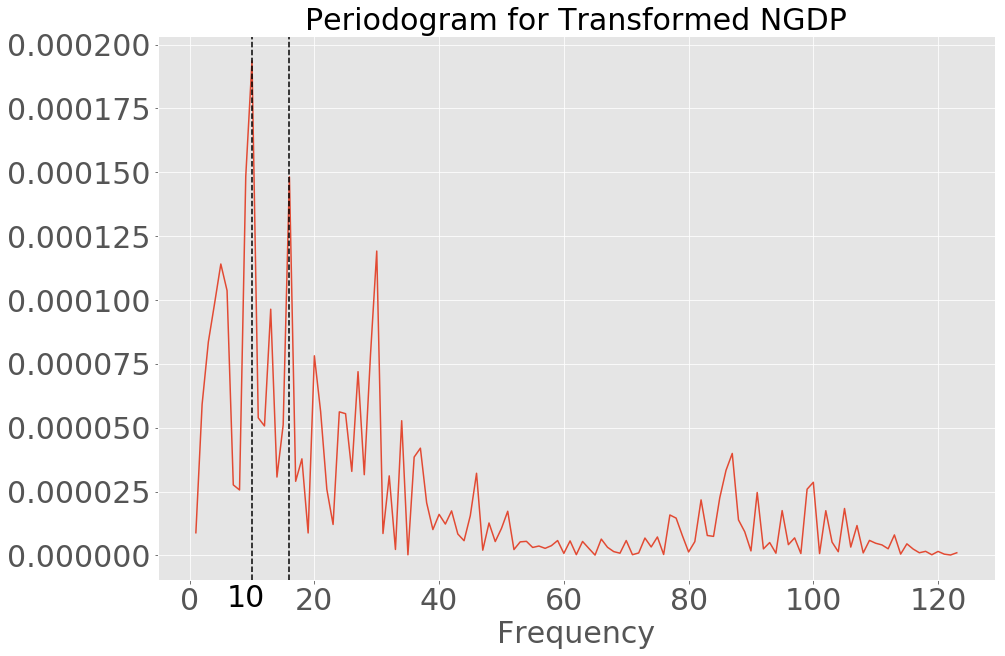

In [66]:
plt.figure(figsize=(15,10))
p1=periodogram(NGDProc_transform)

q1=int((len(p1)-1)/2)
plt.plot(range(1,q1),p1[1:q1])
plt.title('Periodogram for Transformed NGDP',fontsize=30)
plt.xlabel('Frequency',fontsize=30)

plt.axvline(10,color='black',linestyle='--')
plt.axvline(16,color='black',linestyle='--')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.text(6,-0.00002,'10',fontsize=30)
plt.savefig(direc_save+'NGDP_periodogram')

In [67]:
n2=len(NGDProc_transform)
r1=xNGDPsmooth[len(xNGDPsmooth)-1]-xNGDPsmooth[0]
r1=r1[0]
periodNGDP=[]

for i in range(1,q1):
    periodNGDP.append(r1/i)


In [68]:
periodNGDPh=round(periodNGDP[9],2)

Text(6,0,'6.2')

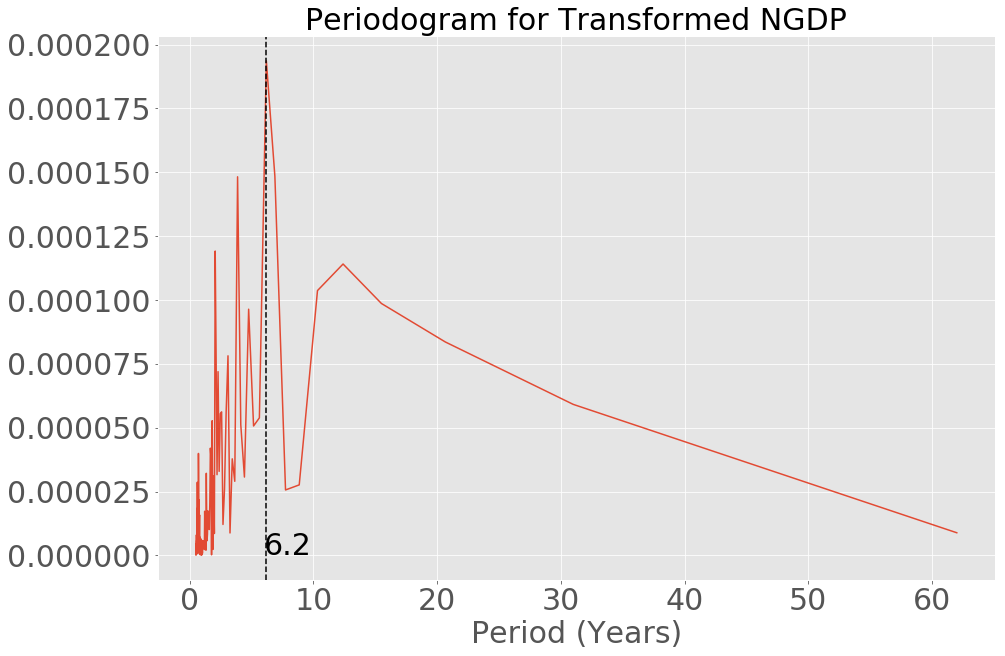

In [69]:
plt.figure(figsize=(15,10))
p1=periodogram(NGDProc_transform)

q1=int((len(p1)-1)/2)
plt.plot(periodNGDP,p1[1:q1])
plt.title('Periodogram for Transformed NGDP',fontsize=30)
plt.xlabel('Period (Years)',fontsize=30)

plt.axvline(periodNGDP[9],color='black',linestyle='--')

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.text(6,0,'{c}'.format(c=periodNGDPh),fontsize=30)

In [70]:
periodNGDPh=round(periodNGDP[9],2)

periods1=[]

years1=[]

for i in range(1,10):
    per1=xNGDPsmooth[0][0]+periodNGDP[9]*i
    y1=periodNGDP[9]*i
    periods1.append(per1)
    years1.append(y1)

In [71]:
periods1

[1962.2, 1968.4, 1974.6, 1980.8, 1987.0, 1993.2, 1999.4, 2005.6, 2011.8]

/home/samuel/.local/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


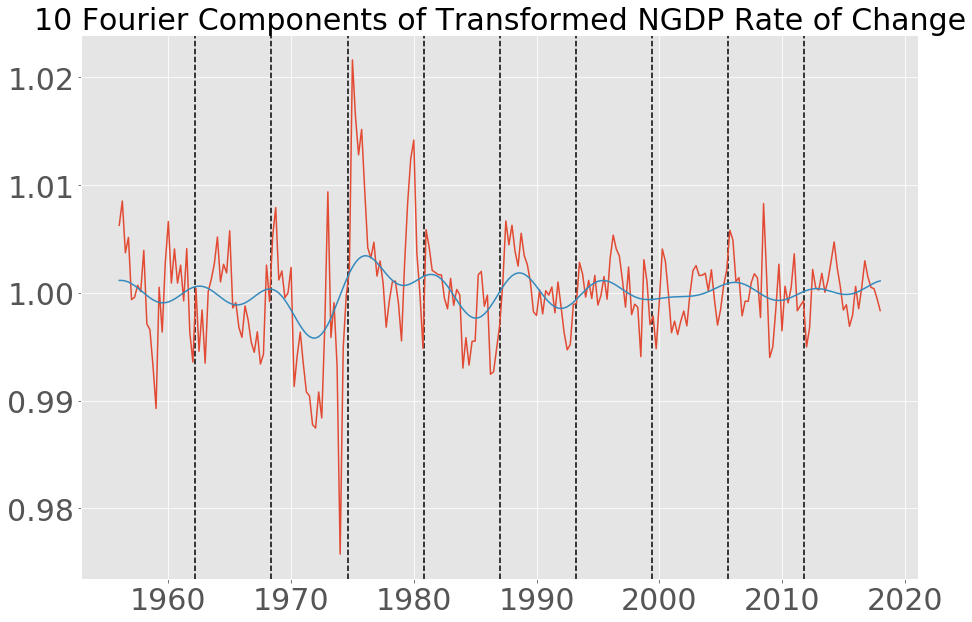

In [72]:
plt.figure(figsize=(15,10))
x1=xNGDPsmooth
y1=NGDProc_transform

n = len(y1)
Y1=np.fft.fft(y1)

for i in range(len(periods1)):
    plt.axvline(periods1[i],color='black',linestyle='--')



c=10
#np.put(Y1, range(0, c), 0.0)
np.put(Y1, range(c+1, n), 0.0)

ifft1=np.fft.ifft(Y1)

plt.plot(x1,y1)
plt.plot(x1,ifft1)

plt.title('{c} Fourier Components of Transformed NGDP Rate of Change'.format(c=c),fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.savefig(direc_save+'NGDP_inv_period')

In [73]:
xl=np.arange(0,(len(xNGDPsmooth)-1)/4,0.25)

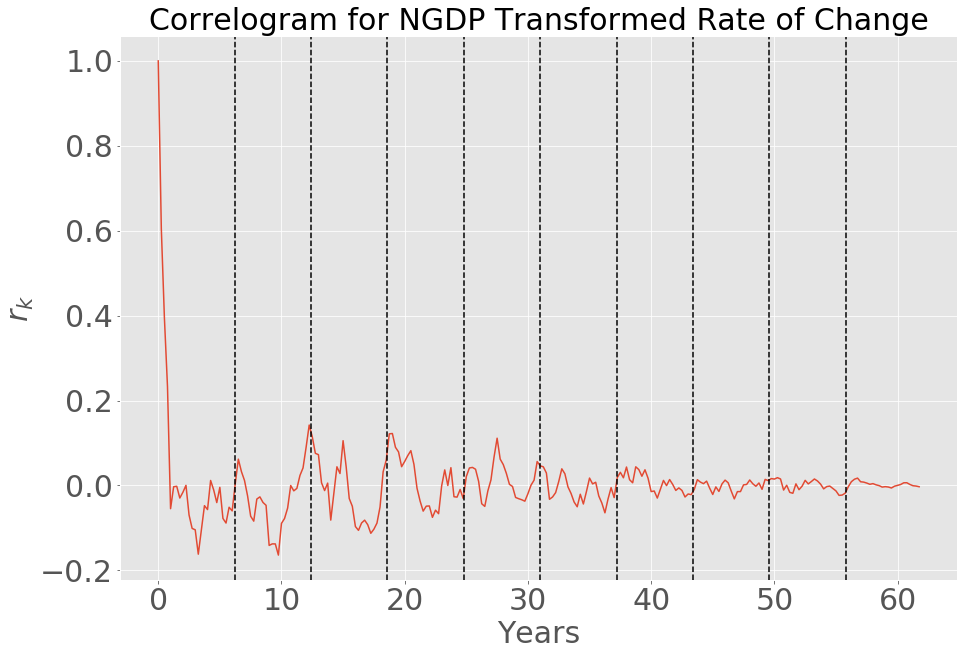

In [74]:
plt.figure(figsize=(15,10))
plt.plot(xl,AUT1(NGDProc_transform))

for i in range(len(years1)):
    plt.axvline(years1[i],color='black',linestyle='--')
plt.title('Correlogram for NGDP Transformed Rate of Change',fontsize=30)
plt.ylabel(r'$r_k$',fontsize=30)
plt.xlabel('Years',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.savefig(direc_save+'NGDP_cor')

/home/samuel/.local/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


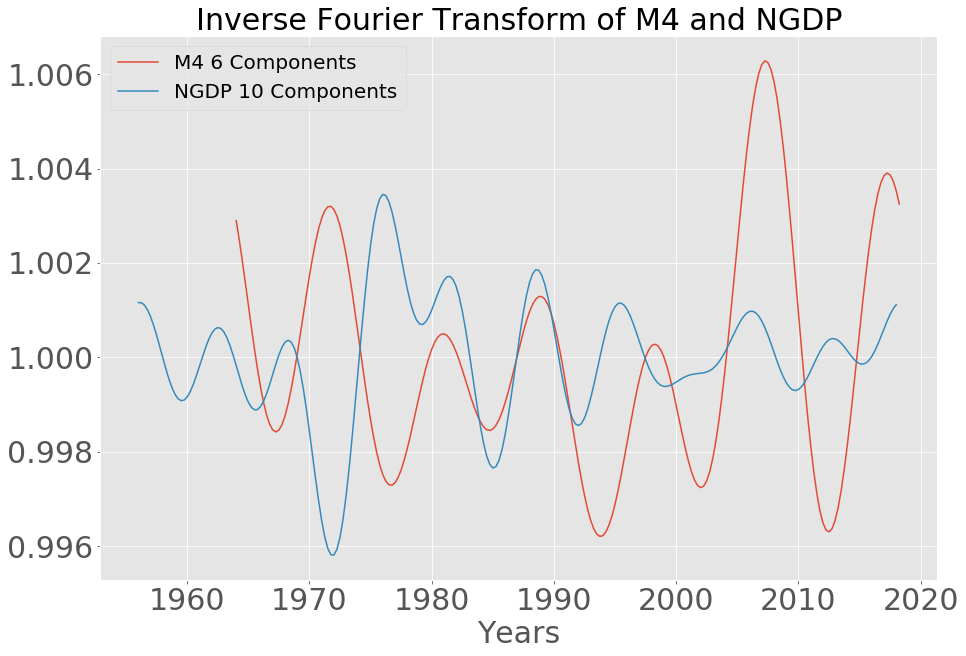

In [75]:
plt.figure(figsize=(15,10))
plt.plot(x,ifft,label='M4 6 Components')
plt.plot(x1,ifft1,label='NGDP 10 Components')

plt.title('Inverse Fourier Transform of M4 and NGDP',fontsize=30)
plt.ylabel('',fontsize=30)
plt.xlabel('Years',fontsize=30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)
plt.savefig(direc_save+'M4_NGDP_Inv_period')

/home/samuel/.local/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(array([0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07]),
 <a list of 10 Text yticklabel objects>)

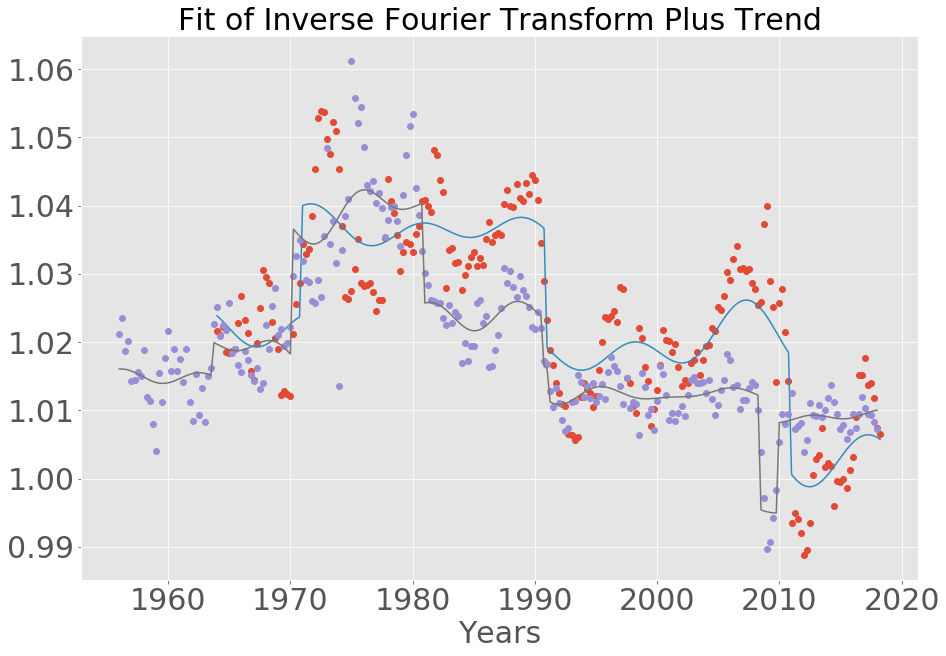

In [113]:
plt.figure(figsize=(15,10))

plt.plot(xM4smooth,yM4smooth,'o')
plt.plot(xM4smooth,ifft*y_1M4smooth)

plt.plot(xNGDPsmooth,yNGDPsmooth,'o')
plt.plot(x1,ifft1*y_2NGDPsmooth)

plt.title('Fit of Inverse Fourier Transform Plus Trend',fontsize=30)
plt.ylabel('',fontsize=30)
plt.xlabel('Years',fontsize=30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Real GDP

In [77]:
RGDP=direc+'UKRGDP.csv'

dataRGDP=pd.read_csv(RGDP)
dataRGDP=dataRGDP.values
xRGDP=dataRGDP[:,0]
yRGDP=dataRGDP[:,1]
#yRGDP=yRGDP.astype(np.float)
datesq=xRGDP[77:len(xRGDP)]
yRGDPq=yRGDP[77:len(yRGDP)]
yRGDPq=np.asarray(yRGDPq,float)

datesRGDP=np.arange(1955,2018.5,0.25)

(array([ 50000., 100000., 150000., 200000., 250000., 300000., 350000.,
        400000., 450000., 500000., 550000.]),
 <a list of 11 Text yticklabel objects>)

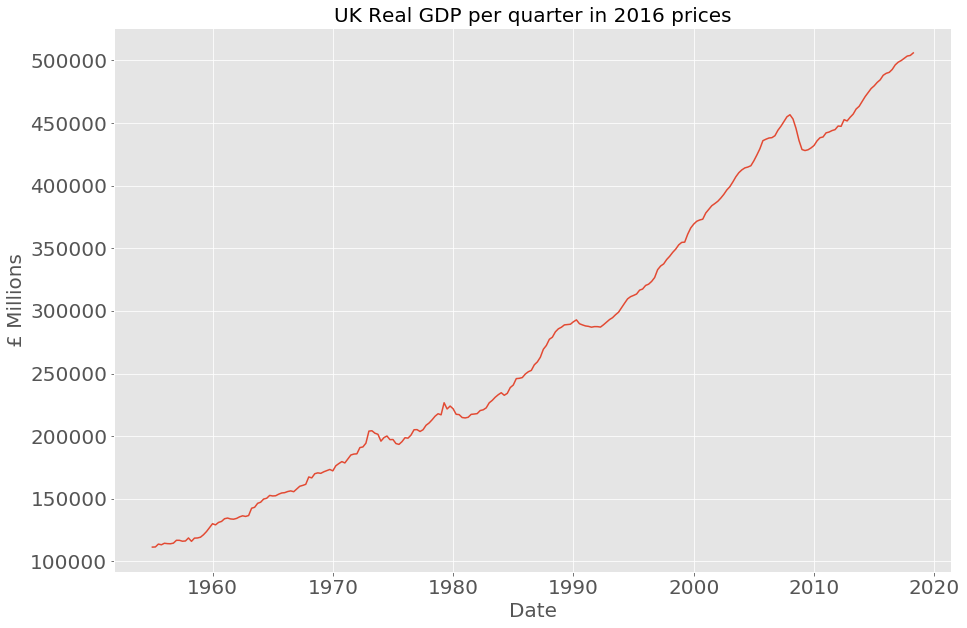

In [78]:
plt.figure(figsize=(15,10))
plt.plot(datesRGDP,yRGDPq)
plt.xlabel('Date',fontsize=20)
plt.ylabel('£ Millions',fontsize=20)
plt.title('UK Real GDP per quarter in 2016 prices',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [79]:
RGDP_rate_of_change=rate_of_change(yRGDPq)
datesRGDProc=datesRGDP[1:len(datesRGDP)]

RGDProc_smooth=running_mean(RGDP_rate_of_change,4)
datesRGDProc_smooth=datesRGDProc[3:len(datesRGDProc)]

In [80]:
r1=adfuller(RGDP_rate_of_change)
r2=adfuller(RGDProc_smooth)

print(r1)
print('')
print(r2)

(-6.895883573630205, 1.3193078789637792e-09, 2, 250, {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}, -1530.0972534478024)

(-3.084479403177709, 0.02772330781688254, 16, 233, {'1%': -3.458731141928624, '5%': -2.8740258764297293, '10%': -2.5734243167124093}, -2092.983264690598)


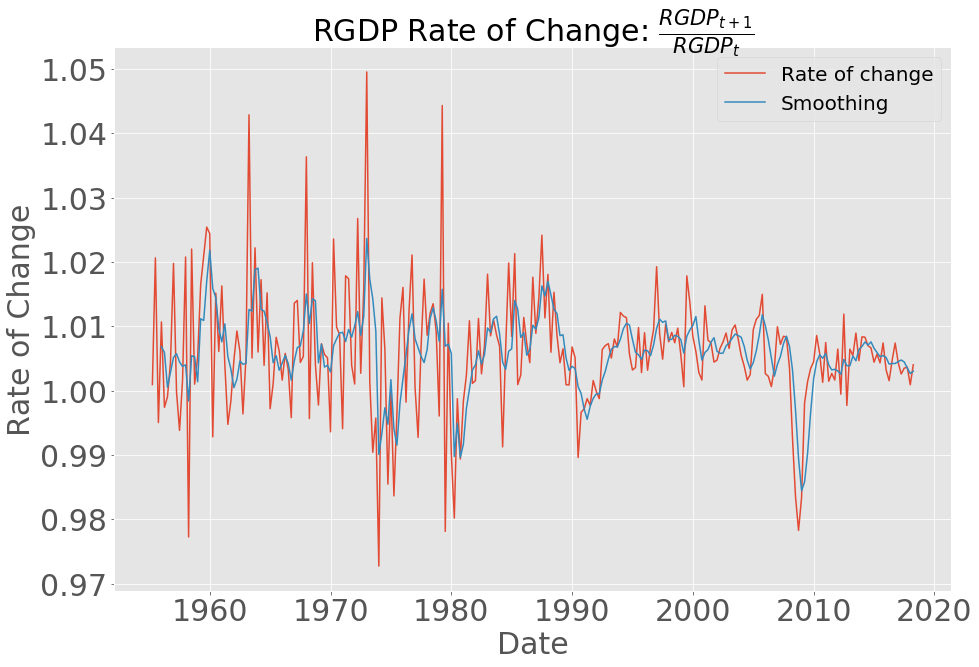

In [81]:
plt.figure(figsize=(15,10))
plt.plot(datesRGDProc,RGDP_rate_of_change,label='Rate of change')
plt.plot(datesRGDProc_smooth,RGDProc_smooth,label='Smoothing')
plt.title(r'RGDP Rate of Change: $\frac{RGDP_{t+1}}{RGDP_{t}}$',fontsize=30)
plt.xlabel('Date',fontsize=30)
plt.ylabel('Rate of Change',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)

(array([-0.0001,  0.    ,  0.0001,  0.0002,  0.0003,  0.0004,  0.0005]),
 <a list of 7 Text yticklabel objects>)

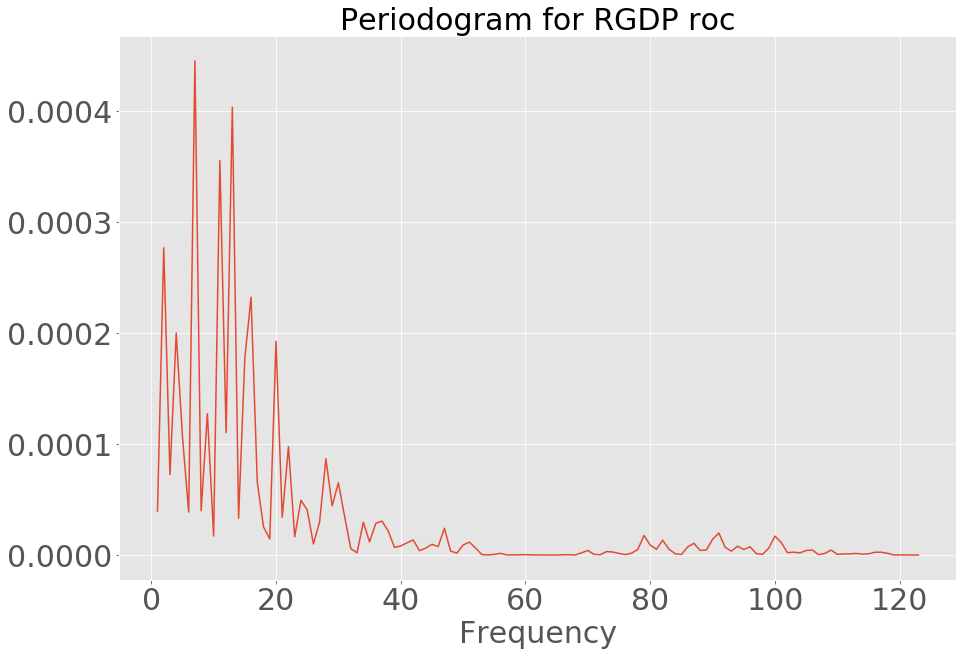

In [82]:
plt.figure(figsize=(15,10))
#p2=periodogram(RGDP_rate_of_change)
p2=periodogram(RGDProc_smooth)

q2=int((len(p2)-1)/2)
plt.plot(range(1,q2),p2[1:q2])
plt.title('Periodogram for RGDP roc',fontsize=30)
plt.xlabel('Frequency',fontsize=30)

# plt.axvline(10,color='black',linestyle='--')
# plt.axvline(16,color='black',linestyle='--')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

#plt.text(6,-0.00002,'10',fontsize=30)

In [83]:
regr_1RGDP = DecisionTreeRegressor(max_depth=2)
regr_2RGDP= DecisionTreeRegressor(max_depth=5)

xRGDPsmooth=datesRGDProc_smooth.reshape(-1,1)
yRGDPsmooth=RGDProc_smooth.reshape(-1,1)

regr_1RGDP.fit(xRGDPsmooth,yRGDPsmooth)
regr_2RGDP.fit(xRGDPsmooth,yRGDPsmooth)

y_1RGDPsmooth = regr_1RGDP.predict(xRGDPsmooth)
y_2RGDPsmooth = regr_2RGDP.predict(xRGDPsmooth)

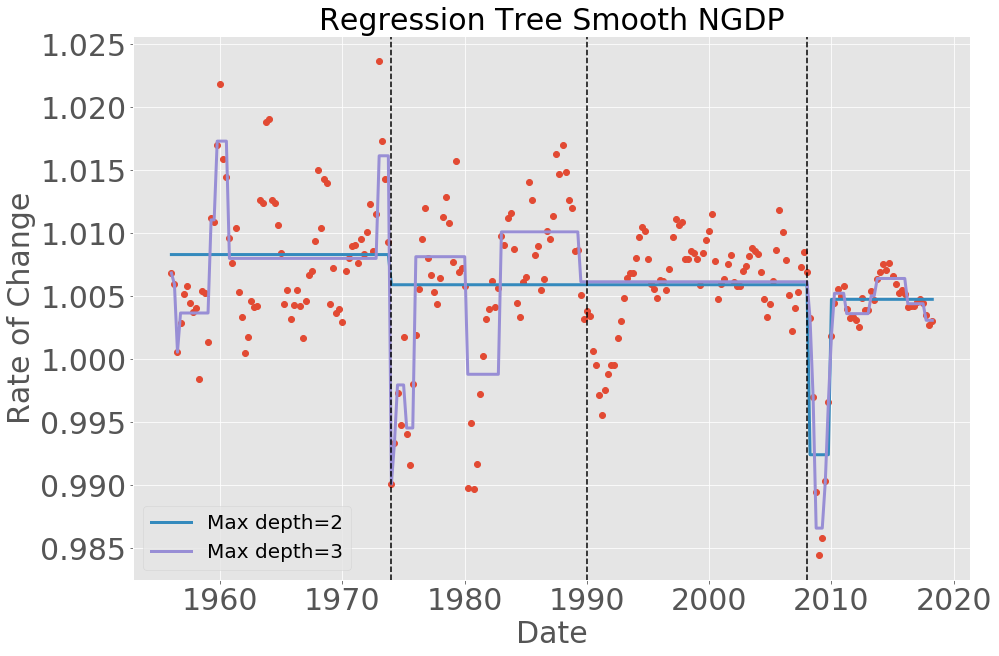

In [84]:
plt.figure(figsize=(15,10))
plt.plot(xRGDPsmooth,yRGDPsmooth,'o')
plt.plot(xRGDPsmooth,y_1RGDPsmooth,linewidth=3,label='Max depth=2')
plt.plot(xRGDPsmooth,y_2RGDPsmooth,linewidth=3,label='Max depth=3')
plt.title('Regression Tree Smooth NGDP',fontsize=30)
plt.xlabel('Date',fontsize=30)
plt.ylabel('Rate of Change',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.axvline(1974,color='black',linestyle='--')
plt.axvline(1990,color='black',linestyle='--')
plt.axvline(2008,color='black',linestyle='--')
plt.legend(fontsize=20)

In [85]:
RGDProc_transform=RGDProc_smooth/y_2RGDPsmooth

(array([-2.0e-05,  0.0e+00,  2.0e-05,  4.0e-05,  6.0e-05,  8.0e-05,
         1.0e-04,  1.2e-04,  1.4e-04]), <a list of 9 Text yticklabel objects>)

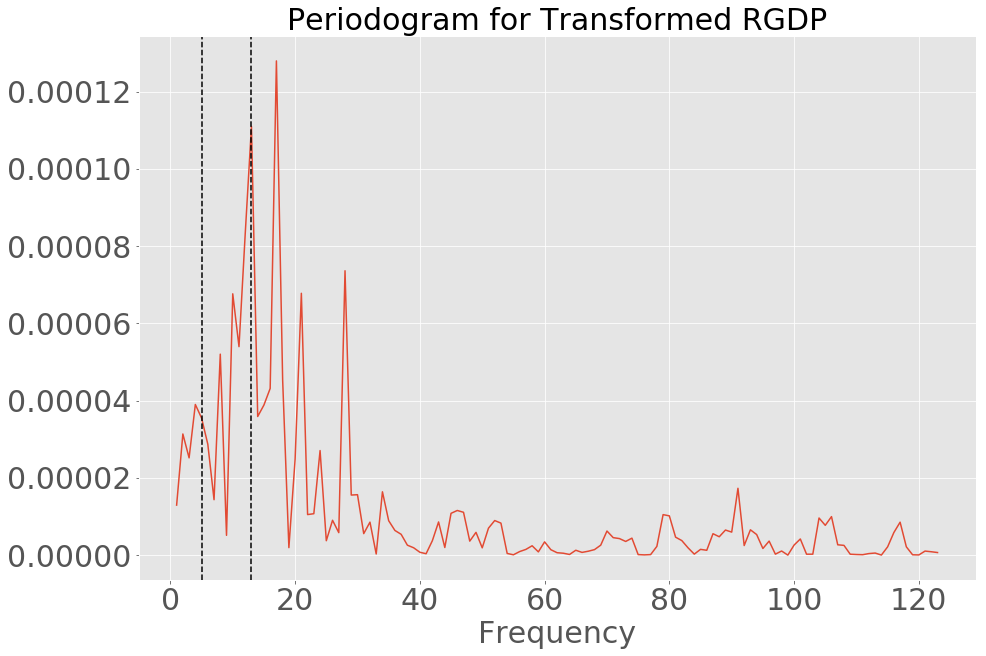

In [86]:
plt.figure(figsize=(15,10))
periodsRGDProc_transform=periodogram(RGDProc_transform)

frequenciesRGDProc=int((len(periodsRGDProc_transform)-1)/2)
plt.plot(range(1,frequenciesRGDProc),periodsRGDProc_transform[1:frequenciesRGDProc])
plt.title('Periodogram for Transformed RGDP',fontsize=30)
plt.xlabel('Frequency',fontsize=30)

plt.axvline(5,color='black',linestyle='--')
plt.axvline(13,color='black',linestyle='--')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

#plt.text(6,-0.00002,'10',fontsize=30)

/home/samuel/.local/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


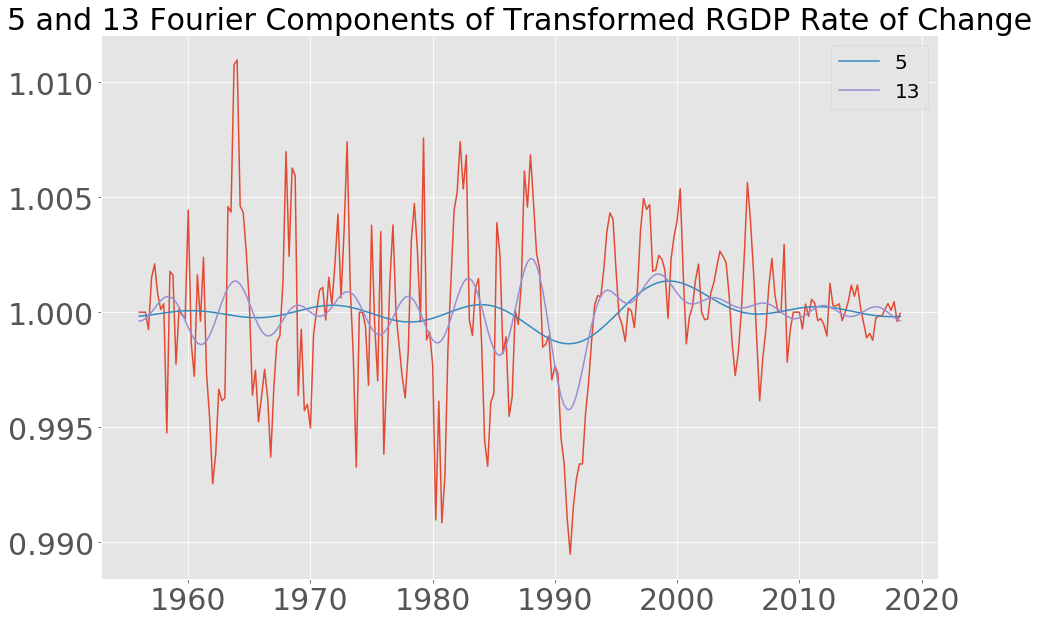

In [87]:
plt.figure(figsize=(15,10))
x3=xRGDPsmooth
y3=RGDProc_transform

n = len(y3)
Y3=np.fft.fft(y3)
Y4=np.fft.fft(y3)

c=5
#np.put(Y1, range(0, c), 0.0)
np.put(Y3, range(c+1, n), 0.0)

c1=13

np.put(Y4, range(c1+1, n), 0.0)

ifft3=np.fft.ifft(Y3)
ifft4=np.fft.ifft(Y4)

plt.plot(x3,y3)
plt.plot(x3,ifft3,label='5')
plt.plot(x3,ifft4,label='13')

plt.title('{c} and {c1} Fourier Components of Transformed RGDP Rate of Change'.format(c=c,c1=c1),fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.legend(fontsize=20)

# Examples

In [140]:
N=100
k=5
f=[]
X=[]
for i in range(N):
    x=2*np.pi* k*i/N
    c=np.cos(x)
    X.append(x)
    f.append(c)

In [141]:
per=(2*np.pi*(N-1))/N

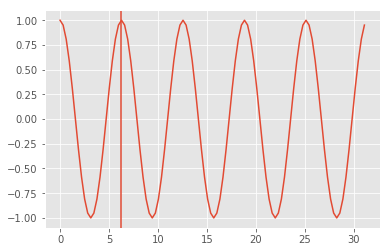

In [142]:
plt.plot(X,f)
plt.axvline(per)

In [143]:
x=np.arange(0,2*np.pi,0.1)

y1=np.sin(3*x)
y2=x+np.sin(3*x)
y3=np.ones(len(x))

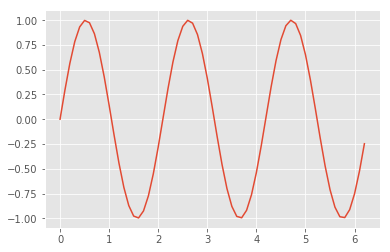

In [144]:
plt.plot(x,y1)

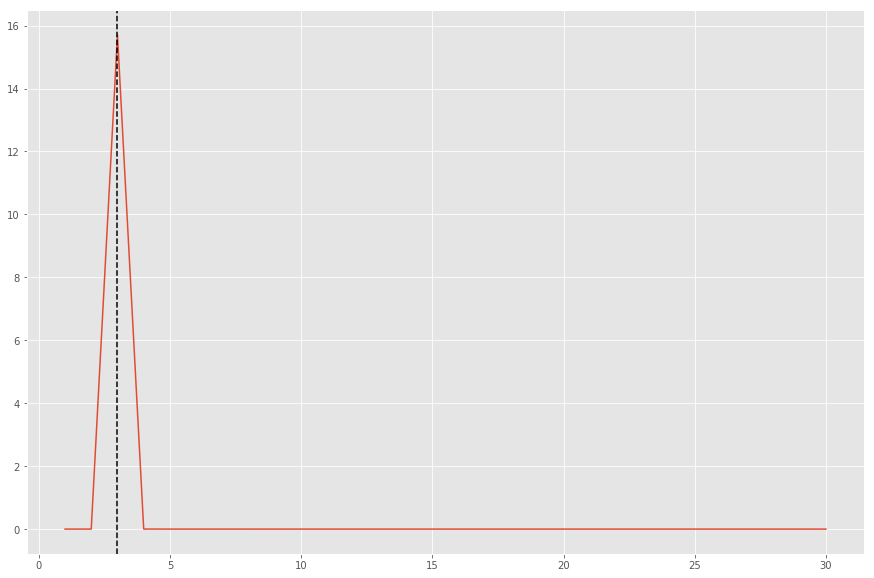

In [145]:
p1=periodogram(y1)

q1=int((len(p1)-1)/2)

plt.figure(figsize=(15,10))

plt.plot(range(1,q1),p1[1:q1])

plt.axvline(3,color='black',linestyle='--')

In [94]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 100)

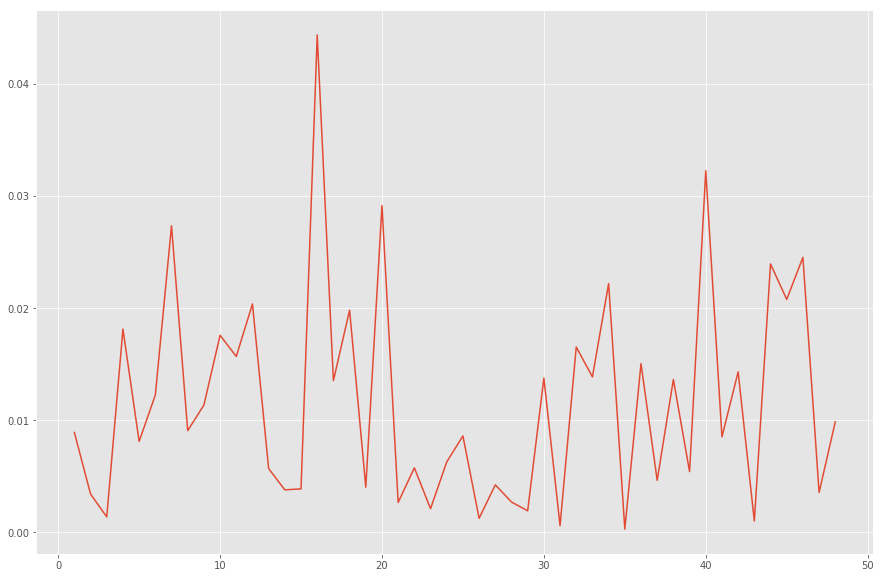

In [95]:
periodogram_rs=periodogram(s)

frequencies_rs=int((len(periodogram_rs)-1)/2)

plt.figure(figsize=(15,10))

plt.plot(range(1,frequencies_rs),periodogram_rs[1:frequencies_rs])

#plt.axvline(3,color='black',linestyle='--')

# Correlations

In [96]:
M4roc_transform1
xM4smooth

array([[1964.  ],
       [1964.25],
       [1964.5 ],
       [1964.75],
       [1965.  ],
       [1965.25],
       [1965.5 ],
       [1965.75],
       [1966.  ],
       [1966.25],
       [1966.5 ],
       [1966.75],
       [1967.  ],
       [1967.25],
       [1967.5 ],
       [1967.75],
       [1968.  ],
       [1968.25],
       [1968.5 ],
       [1968.75],
       [1969.  ],
       [1969.25],
       [1969.5 ],
       [1969.75],
       [1970.  ],
       [1970.25],
       [1970.5 ],
       [1970.75],
       [1971.  ],
       [1971.25],
       [1971.5 ],
       [1971.75],
       [1972.  ],
       [1972.25],
       [1972.5 ],
       [1972.75],
       [1973.  ],
       [1973.25],
       [1973.5 ],
       [1973.75],
       [1974.  ],
       [1974.25],
       [1974.5 ],
       [1974.75],
       [1975.  ],
       [1975.25],
       [1975.5 ],
       [1975.75],
       [1976.  ],
       [1976.25],
       [1976.5 ],
       [1976.75],
       [1977.  ],
       [1977.25],
       [1977.5 ],
       [19

In [97]:
NGDProc_transform
xNGDPsmooth

array([[1956.  ],
       [1956.25],
       [1956.5 ],
       [1956.75],
       [1957.  ],
       [1957.25],
       [1957.5 ],
       [1957.75],
       [1958.  ],
       [1958.25],
       [1958.5 ],
       [1958.75],
       [1959.  ],
       [1959.25],
       [1959.5 ],
       [1959.75],
       [1960.  ],
       [1960.25],
       [1960.5 ],
       [1960.75],
       [1961.  ],
       [1961.25],
       [1961.5 ],
       [1961.75],
       [1962.  ],
       [1962.25],
       [1962.5 ],
       [1962.75],
       [1963.  ],
       [1963.25],
       [1963.5 ],
       [1963.75],
       [1964.  ],
       [1964.25],
       [1964.5 ],
       [1964.75],
       [1965.  ],
       [1965.25],
       [1965.5 ],
       [1965.75],
       [1966.  ],
       [1966.25],
       [1966.5 ],
       [1966.75],
       [1967.  ],
       [1967.25],
       [1967.5 ],
       [1967.75],
       [1968.  ],
       [1968.25],
       [1968.5 ],
       [1968.75],
       [1969.  ],
       [1969.25],
       [1969.5 ],
       [19

In [98]:
xNGDPsmooth1964_2018=xNGDPsmooth[32:]
xM4smooth1964_2018=xM4smooth[:len(xM4smooth)-1]

M4roc_transform1964_2018=M4roc_transform1[:len(M4roc_transform1)-1]
NGDProc_transform1964_2018=NGDProc_transform[32:]

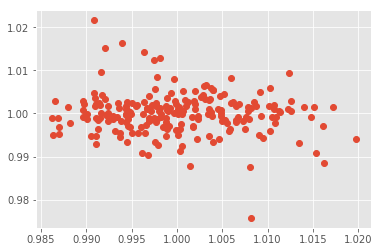

In [99]:
plt.plot(M4roc_transform1964_2018,NGDProc_transform1964_2018,'o')

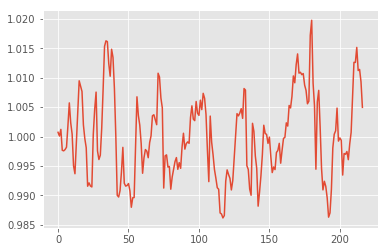

In [100]:
plt.plot(M4roc_transform1964_2018)

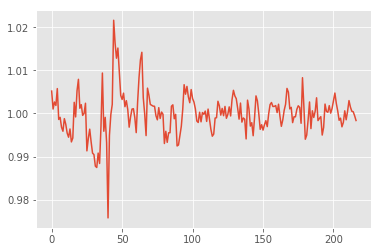

In [101]:
plt.plot(NGDProc_transform1964_2018)

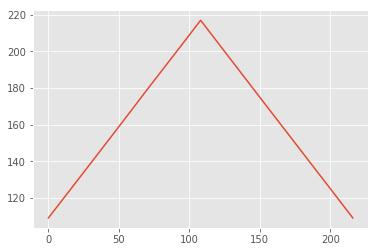

In [146]:
plt.plot(np.correlate(M4roc_transform1964_2018,NGDProc_transform1964_2018,'same'))

In [102]:
from scipy import stats

Test for normality https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
for Pearson's rank correlation coefficient assumption

In [103]:
stats.normaltest(M4roc_transform1964_2018) #does not come from normal distribution

NormaltestResult(statistic=6.649141980702751, pvalue=0.03598795462189171)

In [104]:
stats.normaltest(NGDProc_transform1964_2018)

NormaltestResult(statistic=31.817612311902856, pvalue=1.2328018368525628e-07)

In [105]:
stats.pearsonr(M4roc_transform1964_2018,NGDProc_transform1964_2018)

(-0.10170003855459481, 0.13534377333872263)

In [106]:
stats.spearmanr(M4roc_transform1964_2018,NGDProc_transform1964_2018)

SpearmanrResult(correlation=-0.0018073817274764303, pvalue=0.9788819493997104)

In [107]:
ifft_M4=np.real(ifft)
ifft_M41964_2018=ifft_M4[:len(ifft_M4)-1]
ifft_NGDP=np.real(ifft1)
ifft_NGDP1964_2018=ifft_NGDP[32:]

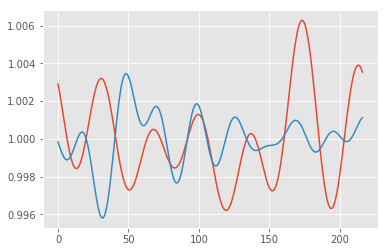

In [108]:
plt.plot(ifft_M41964_2018)
plt.plot(ifft_NGDP1964_2018)

In [109]:
stats.pearsonr(ifft_M41964_2018,ifft_NGDP1964_2018)

(-0.15892678211050273, 0.019153805898997164)

In [110]:
stats.spearmanr(ifft_M41964_2018,ifft_NGDP1964_2018)

SpearmanrResult(correlation=-0.06538400108983122, pvalue=0.337745302221927)

In [155]:
M41963_2018=M4v[:-1]
NGDP1963_2018=NGDP[32:]
# print(datesM4[:-1])
# print(datesNGDP[32:])

In [156]:
stats.pearsonr(M41963_2018,NGDP1963_2018)

(0.9721542250778323, 5.502283513229378e-140)

In [158]:
adfuller(time_dif(M41963_2018))

(-2.445883900223581,
 0.12920242566084938,
 14,
 205,
 {'1%': -3.4626576734812318,
  '10%': -2.5743412314098753,
  '5%': -2.8757444215841326},
 4547.235282453108)